# Setup

In [1]:
from math import nan, isnan, inf, isfinite

import abc
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import shutil
import sys

HOME = os.path.expanduser('~')

# sys.path.insert(0, f'{HOME}/code/slurmqueen') # github.com/vuphan314/slurmqueen
!{sys.executable} -m pip install slurmqueen -q # pypi.org/project/slurmqueen

import slurmqueen
from slurmqueen.experiment import Command
from slurmqueen.slurm_experiment import SlurmExperiment

cerr = print

def getFilePaths(dirPaths, fileNameEnds=set(), excludedFileNameEnds=set()):
    assert isinstance(dirPaths, set), dirPaths
    assert isinstance(fileNameEnds, set), fileNameEnds
    assert isinstance(excludedFileNameEnds, set), excludedFileNameEnds
    filePaths = []
    for dirPath in dirPaths:
        dirPath = os.path.expanduser(dirPath)
        for (subdirPath, _, fileNames) in os.walk(dirPath):
            for fileName in fileNames:
                if not fileNameEnds or any(
                    [fileName.endswith(fileNameEnd) for fileNameEnd in fileNameEnds]
                ):
                    if all([not fileName.endswith(suffix) for suffix in excludedFileNameEnds]):
                        filePath = os.path.join(subdirPath, fileName)
                        filePaths.append(filePath)
    if not filePaths:
        print(f'no matched files in {dirPaths}')
    return sorted(filePaths)

def justifyInt(num, digitCount):
    assert isinstance(num, int), num
    return str(num).rjust(digitCount, '0')

In [2]:
def getRunScript(slurmMemCap, strict):
    script = [
        '',
        f'#SBATCH --mem={slurmMemCap}g',
        f'#SBATCH --mail-type=end'
    ]
    script += [
        '',
        '#SBATCH --exclusive',
        '#SBATCH --constraint=ivybridge'
    ] if strict else []
    script += [
        '',
        'export XALT_EXECUTABLE_TRACKING=no',
        'ml load GCC/10.3.0 Python/3.9.5'
    ]
    return '\n'.join(script)

DEPENDENCIES = [ # these files will be copied to NOTS (/scratch/) by SlurmQueen
    'dpmc.py',
    'wrapper.py',
    'postprocessor.py'
]

In [3]:
class Exp(SlurmExperiment, metaclass=abc.ABCMeta):
    def prepare_server(self, inst): # after copying files and before submitting jobs
        files = [inst.remote_experiment_path(f) for f in DEPENDENCIES]
        cmds = [f'chmod +x {" ".join(files)}']
        for relPath in ['bin', 'benchmarks', 'jointrees']:
            projectPath = f'/projects/vardi/{relPath}'
            scratchPath = inst.remote_experiment_path(relPath)
            cmds.append(f'mkdir -p {os.path.dirname(scratchPath)}')
            cmds.append(f'ln -sf {projectPath} {scratchPath}')
        cmd = ' && '.join(cmds)
        inst.server.execute(cmd)

    def getInst(self):
        netid = 'vhp1'
        return Inst(
            self,
            slurmqueen.ExperimentConfig(
                server=slurmqueen.SlurmServer('nots.rice.edu', netid, f'{HOME}/.ssh/id_rsa'),
                partition='scavenge',
                local_directory=os.getcwd(),
                remote_directory=f'/scratch/{netid}'
            )
        )

    @abc.abstractmethod
    def getWrapperDict(self, benchmarkPath):
        pass

    def getCmd(self, benchmarkPath):
        kwargs = {'cf': benchmarkPath, 'runner': 1}
        return Command(
            './wrapper.py',
            **kwargs,
            **self.getWrapperDict(benchmarkPath),
        ) | Command('./postprocessor.py')

    def getCmds(self):
        cmds = []
        filePaths = getFilePaths(self.benchmarkPaths)
        for i in range(len(filePaths)):
            if not self.actualTasks or i in self.actualTasks:
                cmds.append(self.getCmd(filePaths[i]))
        return cmds

def getIntDigits(num): # SlurmQueen
    return len(str(num))

def copyFile(oldPath, newPath):
    if os.path.exists(newPath):
        raise Exception(f'Existing file: {newPath}')
    shutil.copyfile(oldPath, newPath)

In [4]:
class Inst(slurmqueen.slurm_experiment.SlurmInstance):
    def getTable(self, q):
        df = self.query(q)
        return df.rename(
            columns={
                col: col + self._exp.suffix for col in df.head() if col not in {'file', 'cf', 'base'}
            }
        )

    def runExp(self):
        p = self._exp.id
        if os.path.exists(p):
            answer = input(f'Delete existing local file ({p}) [Y/N]: ')
            if answer.upper() == 'Y':
                shutil.rmtree(p)
            else:
                print(f'Skipped experiment ({p})')
                return
        self.run(len(self._exp.getCmds()), f'0:{self._exp.slurmTimeCap}')

    def checkData(self, allSat=True):
        def checkFile(filePath):
            if os.path.isfile(filePath):
                return True
            else:
                print(f'Missing file:\t{filePath}')
                return False

        benchmarkPaths = getFilePaths(self._exp.benchmarkPaths)
        for i in range(len(benchmarkPaths)):
            checkFile(os.path.join(self._exp.id, f'slurm_{i}.worker'))
            for ext in ['in', 'log', 'out']:
                filePath = os.path.join(
                    self._exp.id,
                    f'{justifyInt(i, getIntDigits(len(benchmarkPaths)))}.{ext}'
                )
                if checkFile(filePath):
                    if not os.path.getsize(filePath):
                        print(f'Empty file:\t{filePath}')
                    elif allSat and os.path.basename(benchmarkPaths[i]) not in open(filePath).readline():
                        print(f'Wrong cf:\t{filePath}')

    def renameFiles(self):
        newDirPath = f'{self._exp.id}Renamed'
        os.makedirs(newDirPath)
        for i in range(len(self._exp.actualTasks)):
            newTask = self._exp.actualTasks[i]

            oldPath = os.path.join(self._exp.id, f'slurm_{i}.worker')
            newPath = os.path.join(newDirPath, f'slurm_{newTask}.worker')
            copyFile(oldPath, newPath)
            for ext in ['in', 'log', 'out']:
                oldDigits = getIntDigits(len(self._exp.actualTasks))
                newDigits = getIntDigits(len(getFilePaths(self._exp.benchmarkPaths)))
                oldPath = os.path.join(self._exp.id, f'{justifyInt(i, oldDigits)}.{ext}')
                newPath = os.path.join(newDirPath, f'{justifyInt(newTask, newDigits)}.{ext}')
                try:
                    copyFile(oldPath, newPath)
                except FileNotFoundError as e:
                    print(e)

# Experiments

In [5]:
SLURM_TIME = 1200
RUNNER_TIME = 1100
TIME = 1000

HI_SLURM_MEM = 120
HI_RUNNER_MEM = 110
HI_MEM = 100

LO_SLURM_MEM = 28
LO_RUNNER_MEM = 26
LO_MEM = 25

DIFF = 1e-6

## Planners

In [6]:
class PlannerExp(Exp):
    def __init__(
        self,
        decomposer,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.decomposer = decomposer
        self.suffix = suffix
        self.benchmarkPaths = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'planner',
            'decomposer': self.decomposer,
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'pc': 1
        }

### WPMC benchmarks

In [7]:
WPMC_PLAN_HTD_INST = PlannerExp(
    decomposer='htd',
    suffix='Htd',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/planner/htd',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# WPMC_PLAN_HTD_INST.runExp()
# WPMC_PLAN_HTD_INST._gather()
# WPMC_PLAN_HTD_INST.renameFiles()
WPMC_PLAN_HTD_INST.checkData()

In [8]:
WPMC_PLAN_FLOW_INST = PlannerExp(
    decomposer='flow',
    suffix='F',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/planner/flow',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# WPMC_PLAN_FLOW_INST.runExp()
# WPMC_PLAN_FLOW_INST._gather()
# WPMC_PLAN_FLOW_INST.renameFiles()
WPMC_PLAN_FLOW_INST.checkData()

## DMC

In [9]:
class DmcExp(Exp):
    def __init__(
        self,
        ma,
        dp,
        decomposer,
        pw,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.ma = ma
        self.dp = dp
        self.decomposer = decomposer
        self.pw = pw
        self.suffix = suffix
        self.benchmarkPaths = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=True)
        )

    def getWrapperDict(self, benchmarkPath):
        jtPath = benchmarkPath.replace('benchmarks/cnf', f'jointrees/{self.decomposer}')
        jtPath = jtPath.replace('.cnf', '.jt')
        return {
            'solver': 'dmc',
            'jf': jtPath,
            'ma': self.ma,
            'dp': self.dp,
            'pw': self.pw,
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'wc': 1,
            'pc': 1,
            'er': 1,
        }

### WPMC benchmarks

#### CUDD

In [10]:
WPMC_DMC_CUDD_HTD_INST = DmcExp(
    ma=0,
    dp='c',
    decomposer='htd',
    pw=0,
    suffix='DmCHtd',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/dmc/cudd/htd',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
WPMC_DMC_CUDD_HTD_INST.checkData()

In [11]:
WPMC_DMC_CUDD_HTD_LAST_INST = DmcExp(
    ma=0,
    dp='c',
    decomposer='htd',
    pw=1000,
    suffix='DmCHtdL',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/dmc/cudd/htd1000s',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# WPMC_DMC_CUDD_HTD_LAST_INST.runExp()
# WPMC_DMC_CUDD_HTD_LAST_INST._gather()
# WPMC_DMC_CUDD_HTD_LAST_INST.renameFiles()
WPMC_DMC_CUDD_HTD_LAST_INST.checkData()

In [12]:
WPMC_DMC_CUDD_FLOW_INST = DmcExp(
    ma=0,
    dp='c',
    decomposer='flow',
    pw=0,
    suffix='DmCF',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/dmc/cudd/flow',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
WPMC_DMC_CUDD_FLOW_INST.checkData()

In [13]:
WPMC_DMC_CUDD_FLOW_LAST_INST = DmcExp(
    ma=0,
    dp='c',
    decomposer='flow',
    pw=1000,
    suffix='DmCFL',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/dmc/cudd/flow1000s',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# WPMC_DMC_CUDD_FLOW_LAST_INST.runExp()
# WPMC_DMC_CUDD_FLOW_LAST_INST._gather()
# WPMC_DMC_CUDD_FLOW_LAST_INST.renameFiles()
WPMC_DMC_CUDD_FLOW_LAST_INST.checkData()

#### Sylvan

In [14]:
WPMC_DMC_SYLVAN_HTD_INST = DmcExp(
    ma=0,
    dp='s',
    decomposer='htd',
    pw=0,
    suffix='DmSHtd',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/dmc/sylvan/htd',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
WPMC_DMC_SYLVAN_HTD_INST.checkData()

In [15]:
WPMC_DMC_SYLVAN_FLOW_INST = DmcExp(
    ma=0,
    dp='s',
    decomposer='flow',
    pw=0,
    suffix='DmSF',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/dmc/sylvan/flow',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
WPMC_DMC_SYLVAN_FLOW_INST.checkData()

## DPMC

In [16]:
class DpmcExp(Exp):
    def __init__(
        self,
        ma,
        dp,
        decomposer,
        pw,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.ma = ma
        self.dp = dp
        self.decomposer = decomposer
        self.pw = pw
        self.suffix = suffix
        self.benchmarkPaths = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'dpmc',
            'ma': self.ma,
            'dp': self.dp,
            'decomposer': self.decomposer,
            'pw': self.pw,
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'wc': 1,
            'pc': 1,
            'er': 1,
        }

### WPMC benchmarks

#### High mem

In [17]:
HI_WPMC_DPMC_CUDD_HTD_INST = DpmcExp(
    ma=1,
    dp='c',
    decomposer='htd',
    pw=0,
    suffix='DpCHtd',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem1/wpmc/dpmc/cudd/htd',
    memCap=HI_RUNNER_MEM,
    slurmMemCap=HI_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# HI_WPMC_DPMC_CUDD_HTD_INST.runExp()
# HI_WPMC_DPMC_CUDD_HTD_INST._gather()
# HI_WPMC_DPMC_CUDD_HTD_INST.renameFiles()
HI_WPMC_DPMC_CUDD_HTD_INST.checkData()

In [18]:
HI_WPMC_DPMC_CUDD_HTD_10S_INST = DpmcExp(
    ma=1,
    dp='c',
    decomposer='htd',
    pw=10,
    suffix='DpCHtd10s',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem1/wpmc/dpmc/cudd/htd10s',
    memCap=HI_RUNNER_MEM,
    slurmMemCap=HI_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# HI_WPMC_DPMC_CUDD_HTD_10S_INST.runExp()
# HI_WPMC_DPMC_CUDD_HTD_10S_INST._gather()
# HI_WPMC_DPMC_CUDD_HTD_10S_INST.renameFiles()
HI_WPMC_DPMC_CUDD_HTD_10S_INST.checkData()

In [19]:
HI_WPMC_DPMC_CUDD_FLOW_INST = DpmcExp(
    ma=1,
    dp='c',
    decomposer='flow',
    pw=0,
    suffix='DpCF',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem1/wpmc/dpmc/cudd/flow',
    memCap=HI_RUNNER_MEM,
    slurmMemCap=HI_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# HI_WPMC_DPMC_CUDD_FLOW_INST.runExp()
# HI_WPMC_DPMC_CUDD_FLOW_INST._gather()
# HI_WPMC_DPMC_CUDD_FLOW_INST.renameFiles()
HI_WPMC_DPMC_CUDD_FLOW_INST.checkData()

In [20]:
HI_WPMC_DPMC_CUDD_FLOW_5S_INST = DpmcExp(
    ma=1,
    dp='c',
    decomposer='flow',
    pw=5,
    suffix='DpCF5s',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem1/wpmc/dpmc/cudd/flow5s',
    memCap=HI_RUNNER_MEM,
    slurmMemCap=HI_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# HI_WPMC_DPMC_CUDD_FLOW_5S_INST.runExp()
# HI_WPMC_DPMC_CUDD_FLOW_5S_INST._gather()
# HI_WPMC_DPMC_CUDD_FLOW_5S_INST.renameFiles()
HI_WPMC_DPMC_CUDD_FLOW_5S_INST.checkData()

#### Low mem

In [21]:
LO_WPMC_DPMC_CUDD_FLOW_INST = DpmcExp(
    ma=0,
    dp='c',
    decomposer='flow',
    pw=0,
    suffix='DpC',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/dpmc/cudd',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
LO_WPMC_DPMC_CUDD_FLOW_INST.checkData()

In [22]:
LO_WPMC_DPMC_SYLVAN_FLOW_INST = DpmcExp(
    ma=0,
    dp='s',
    decomposer='flow',
    pw=0,
    suffix='DpS',
    benchmarksPath='benchmarks/cnf/wpmc',
    dataPath='data/mem0/wpmc/dpmc/sylvan',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
LO_WPMC_DPMC_SYLVAN_FLOW_INST.checkData()

### Justicia benchmarks

In [23]:
JUST_DPMC_SYLVAN_INST = DpmcExp(
    ma=0,
    dp='s',
    decomposer='flow',
    pw=0,
    suffix='DpS',
    benchmarksPath='benchmarks/cnf/justicia',
    dataPath='data/mem0/justicia/dpmc/sylvan',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
JUST_DPMC_SYLVAN_INST.checkData()

## erSSAT

In [24]:
class ErssatExp(Exp):
    def __init__(
        self,
        greedy,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.greedy = greedy
        self.suffix = suffix
        self.benchmarkPaths = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'erssat',
            'extra': '' if self.greedy else '-g',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

### WPMC benchmarks

In [25]:
HI_WPMC_ERSSAT_GREED_INST = ErssatExp(
    greedy=True,
    suffix='EGH',
    benchmarksPath='benchmarks/sdimacs/wpmc',
    dataPath='data/mem1/wpmc/erssat/greed',
    memCap=HI_RUNNER_MEM,
    slurmMemCap=HI_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# HI_WPMC_ERSSAT_GREED_INST.runExp()
# HI_WPMC_ERSSAT_GREED_INST._gather()
# HI_WPMC_ERSSAT_GREED_INST.renameFiles()
HI_WPMC_ERSSAT_GREED_INST.checkData()

In [26]:
LO_WPMC_ERSSAT_GREED_INST = ErssatExp(
    greedy=True,
    suffix='EG',
    benchmarksPath='benchmarks/sdimacs/wpmc',
    dataPath='data/mem0/wpmc/erssat/greed',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
LO_WPMC_ERSSAT_GREED_INST.checkData()

In [27]:
LO_WPMC_ERSSAT_NOGREED_INST = ErssatExp(
    greedy=False,
    suffix='EN',
    benchmarksPath='benchmarks/sdimacs/wpmc',
    dataPath='data/mem0/wpmc/erssat/nogreed',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
LO_WPMC_ERSSAT_NOGREED_INST.checkData()

### Justicia benchmarks

In [28]:
JUST_ERSSAT_NOGREED_INST = ErssatExp(
    greedy=False,
    suffix='EN',
    benchmarksPath='benchmarks/sdimacs/justicia',
    dataPath='data/mem0/justicia/erssat/nogreed',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
JUST_ERSSAT_NOGREED_INST.checkData()

## DC-SSAT

In [29]:
class DcssatExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarkPaths = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'dcssat',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

### WPMC benchmarks

In [30]:
HI_WPMC_DCSSAT_INST = DcssatExp(
    suffix = 'DcH',
    benchmarksPath='benchmarks/sdimacs/wpmc',
    dataPath='data/mem1/wpmc/dcssat',
    memCap=HI_RUNNER_MEM,
    slurmMemCap=HI_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# HI_WPMC_DCSSAT_INST.runExp()
# HI_WPMC_DCSSAT_INST._gather()
HI_WPMC_DCSSAT_INST.checkData()

In [31]:
LO_WPMC_DCSSAT_INST = DcssatExp(
    suffix = 'Dc',
    benchmarksPath='benchmarks/sdimacs/wpmc',
    dataPath='data/mem0/wpmc/dcssat',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
LO_WPMC_DCSSAT_INST.checkData()

### Justicia benchmarks

In [32]:
JUST_DCSSAT_INST = DcssatExp(
    suffix = 'Dc',
    benchmarksPath='benchmarks/sdimacs/justicia',
    dataPath='data/mem0/justicia/dcssat',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
JUST_DCSSAT_INST.checkData()

## CryptoMiniSat

In [33]:
class CmsatExp(Exp):
    def __init__(
        self,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.benchmarkPaths = {benchmarksPath}
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strict=False)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'minisat',
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'vs': 0
        }

### Justicia benchmarks

In [34]:
JUST_CMSAT_INST = CmsatExp(
    benchmarksPath='benchmarks/cnf/justicia',
    dataPath='data/mem0/justicia/cmsat',
    memCap=LO_RUNNER_MEM,
    slurmMemCap=LO_SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
JUST_CMSAT_INST.checkData()

# Analysis

## WPMC benchmarks

### Planners

#### htd

In [35]:
trees = ', '.join([f'treetime{i}, width{i}' for i in range(1, 10)])
q = f'select file, mem, time, treetime, width, treecount, {trees} from data '
# q = 'select * from data '

q += 'where width is not null '
# q += 'and treetime1 < 1000 '
q += 'order by width'

WPMC_PLAN_HTD_INST.query(q)

,file,mem,time,treetime,width,treecount,treetime1,width1,treetime2,width2,...,treetime5,width5,treetime6,width6,treetime7,width7,treetime8,width8,treetime9,width9
0,754,0.033156,1010.06,0.100298,1.0,1.0,0.100298,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,755,0.028944,1010.06,1009.800000,1.0,3.0,0.035937,1.0,0.036451,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,680,0.034768,1010.06,1009.850000,4.0,3.0,0.039461,25.0,0.039798,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,681,0.032376,1010.06,1009.860000,4.0,3.0,0.036160,13.0,0.036349,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,682,0.032432,1010.06,1009.850000,4.0,3.0,0.037648,17.0,0.037897,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,292,0.034584,1010.05,0.044209,97.0,1.0,0.044209,97.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,293,0.028320,1010.05,0.044298,97.0,1.0,0.044298,97.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,173,0.073672,1010.06,31.053300,98.0,2.0,4.067590,100.0,31.053300,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,706,0.139652,1010.07,342.496000,100.0,1.0,342.496000,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### FlowCutter

In [36]:
trees = ', '.join([f'treetime{i}, width{i}' for i in range(1, 6)])
q = f'select file, cf, mem, time, treetime, width, treecount, {trees} from data '

q += 'where width is not null '
q += 'and treetime1 < 1000 '
q += 'order by treetime1'

WPMC_PLAN_FLOW_INST.query(q)#['file'].tolist()

,file,cf,mem,time,treetime,width,treecount,treetime1,width1,treetime2,width2,treetime3,width3,treetime4,width4,treetime5,width5
0,684,benchmarks/cnf/wpmc/bird/s27_new_3_2.no_w.cnf,0.047788,1010.06,1009.86000,4.0,2.0,0.011909,4.0,1009.86,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,779,benchmarks/cnf/wpmc/waps/s27_7_4.cnf,0.044008,1010.06,1009.85000,4.0,2.0,0.012070,4.0,1009.85,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,683,benchmarks/cnf/wpmc/bird/s27_new_15_7.no_w.cnf,0.041700,1010.05,1009.86000,4.0,2.0,0.012074,4.0,1009.86,4.0,NaN,NaN,NaN,NaN,NaN,NaN
3,685,benchmarks/cnf/wpmc/bird/s27_new_7_4.no_w.cnf,0.047600,1010.05,1009.85000,4.0,2.0,0.012078,4.0,1009.85,4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,682,benchmarks/cnf/wpmc/bird/s27_7_4.no_w.cnf,0.046136,1010.05,1009.85000,4.0,2.0,0.012078,4.0,1009.85,4.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,798,benchmarks/cnf/wpmc/waps/s38417_15_7.cnf,0.108004,1010.06,5.56705,58.0,1.0,5.567050,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,175,benchmarks/cnf/wpmc/bird/NotificationServiceIm...,0.035052,1010.05,6.90602,91.0,1.0,6.906020,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,179,benchmarks/cnf/wpmc/bird/ProjectService3.sk_12...,0.036276,1010.05,7.39272,76.0,1.0,7.392720,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,178,benchmarks/cnf/wpmc/bird/ProcessBean.sk_8_64.n...,0.042236,1010.05,8.25239,89.0,1.0,8.252390,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DMC

#### CUDD

##### htd

In [37]:
q = 'select file, sol, mem, time, treetime, exetime, dvtime, width, treecount from data '
# q = 'select * from data '

q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by treecount'

WPMC_DMC_CUDD_HTD_INST.query(q)

,file,sol,mem,time,treetime,exetime,dvtime,width,treecount
0,68,1.337420e-05,0.308068,0.561983,0.067372,0.494611,0.003,81.0,1.0
1,146,4.299820e-04,0.547976,2.478252,0.068142,2.410110,0.003,87.0,1.0
2,165,2.021710e-07,0.531728,2.398227,0.101777,2.296450,0.007,77.0,1.0
3,166,3.993500e-08,0.797856,7.476923,0.107553,7.369370,0.008,78.0,1.0
4,169,8.985370e-08,0.446948,2.093688,0.064468,2.029220,0.002,49.0,1.0
...,...,...,...,...,...,...,...,...,...
207,841,1.950080e-07,0.288856,0.366709,0.049806,0.316903,0.000,48.0,1.0
208,842,3.505560e-07,0.194504,0.390880,0.048652,0.342228,0.000,48.0,1.0
209,846,1.081900e-03,0.749012,8.211259,0.071559,8.139700,0.000,88.0,1.0
210,847,9.565240e-04,0.598584,6.901108,0.068988,6.832120,0.000,98.0,1.0


In [38]:
trees = ', '.join([f'treetime{i}, width{i}' for i in range(1, 10)])
q = f'select file, sol, mem, time, treetime, exetime, dvtime, width, treecount, {trees} from data '
# q = 'select * from data '

q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by treecount'

WPMC_DMC_CUDD_HTD_LAST_INST.query(q)

,file,sol,mem,time,treetime,exetime,dvtime,width,treecount,treetime1,...,treetime5,width5,treetime6,width6,treetime7,width7,treetime8,width8,treetime9,width9
0,68,1.337420e-05,0.310360,0.483565,0.067372,0.416193,0.003,81.0,1.0,0.067372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,146,4.299820e-04,0.517284,2.747392,0.068142,2.679250,0.003,87.0,1.0,0.068142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,169,8.985370e-08,0.448728,1.892918,0.064468,1.828450,0.002,49.0,1.0,0.064468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,170,8.985370e-08,0.244360,0.425011,0.054194,0.370817,0.001,49.0,1.0,0.054194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,181,1.380150e-09,0.204828,0.465350,0.085810,0.379540,0.005,61.0,1.0,0.085810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,798,2.732920e-186,1.793164,523.487900,501.525000,21.962900,1.146,40.0,7.0,4.898490,...,24.331200,42.0,30.917900,41.0,501.5250,40.0,NaN,NaN,NaN,NaN
157,799,1.143760e-188,9.743784,425.705000,255.669000,170.036000,1.028,40.0,7.0,4.790440,...,22.524900,42.0,34.535400,41.0,255.6690,40.0,NaN,NaN,NaN,NaN
158,847,9.565240e-04,0.632684,52.599500,41.808900,10.790600,0.000,82.0,7.0,0.068988,...,0.489623,84.0,0.800547,83.0,41.8089,82.0,NaN,NaN,NaN,NaN
159,166,3.993500e-08,0.594700,43.650300,41.183800,2.466500,0.007,56.0,8.0,0.107553,...,0.402516,60.0,0.926092,58.0,15.4345,57.0,41.1838,56.0,NaN,NaN


##### FlowCutter

In [39]:
q = 'select file, sol, mem, time, treetime, exetime, dvtime, width, treecount from data '
# q = 'select * from data '

q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by treecount'

WPMC_DMC_CUDD_FLOW_INST.query(q)

,file,sol,mem,time,treetime,exetime,dvtime,width,treecount
0,68,1.337420e-05,0.308712,0.507880,0.038375,0.469505,0.003,81.0,1.0
1,146,4.299820e-04,0.559840,2.018316,0.054926,1.963390,0.003,87.0,1.0
2,165,2.021710e-07,1.461664,10.144531,0.113031,10.031500,0.007,73.0,1.0
3,166,3.993500e-08,4.814252,56.384980,0.135680,56.249300,0.007,77.0,1.0
4,169,8.985370e-08,0.458352,2.131150,0.045180,2.085970,0.002,49.0,1.0
...,...,...,...,...,...,...,...,...,...
199,841,1.950080e-07,0.299104,0.340775,0.027377,0.313398,0.000,48.0,1.0
200,842,3.505560e-07,0.235608,0.351196,0.027533,0.323663,0.000,48.0,1.0
201,846,1.081900e-03,2.350692,68.812941,0.043941,68.769000,0.000,100.0,1.0
202,847,9.565240e-04,0.603792,9.179720,1.453010,7.726710,0.000,95.0,1.0


In [40]:
trees = ', '.join([f'treetime{i}, width{i}' for i in range(1, 6)])
q = f'select file, sol, mem, time, treetime, exetime, dvtime, width, treecount, {trees} from data '
# q = 'select * from data '

q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by treetime'

WPMC_DMC_CUDD_FLOW_LAST_INST.query(q)

,file,sol,mem,time,treetime,exetime,dvtime,width,treecount,treetime1,width1,treetime2,width2,treetime3,width3,treetime4,width4,treetime5,width5
0,283,5.804750e-04,0.247988,0.315403,0.012677,0.302726,0.000,16.0,1.0,0.012677,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,275,8.707130e-04,0.209924,0.336898,0.013029,0.323869,0.000,17.0,1.0,0.013029,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,281,5.804750e-04,0.135500,0.404945,0.013337,0.391608,0.000,17.0,1.0,0.013337,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,282,1.306070e-03,0.298288,0.318490,0.013367,0.305123,0.000,18.0,1.0,0.013367,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,277,5.804750e-04,0.136784,0.412904,0.013551,0.399353,0.000,16.0,1.0,0.013551,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,703,2.315760e-308,2.268212,21.606170,5.396170,16.210000,1.126,55.0,1.0,5.396170,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,701,2.685980e-309,4.593124,56.356130,5.433330,50.922800,1.110,58.0,1.0,5.433330,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,175,3.105350e-09,0.852952,13.666840,6.906020,6.760820,0.026,91.0,1.0,6.906020,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,263,1.834960e-27,0.527980,39.876780,36.622100,3.254680,0.001,53.0,5.0,0.044147,58.0,0.316252,55.0,0.515728,56.0,0.522932,53.0,36.6221,53.0


#### Sylvan

##### htd

In [41]:
q = 'select file, sol, mem, time, treetime, exetime, dvtime, width, treecount from data '
# q = 'select * from data '

q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by treecount'

WPMC_DMC_SYLVAN_HTD_INST.query(q)

,file,sol,mem,time,treetime,exetime,dvtime,width,treecount
0,68,1.337420e-05,0.055480,0.437056,0.067372,0.369684,0.003,81.0,1.0
1,146,4.299820e-04,0.180572,2.436402,0.068142,2.368260,0.003,87.0,1.0
2,165,2.021710e-07,0.181436,2.990927,0.101777,2.889150,0.007,77.0,1.0
3,166,3.993500e-08,0.590848,12.692453,0.107553,12.584900,0.007,78.0,1.0
4,169,8.985370e-08,0.173492,1.981848,0.064468,1.917380,0.002,49.0,1.0
...,...,...,...,...,...,...,...,...,...
196,841,1.950080e-07,0.019120,0.322185,0.049806,0.272379,0.000,48.0,1.0
197,842,3.505560e-07,0.022676,0.336047,0.048652,0.287395,0.000,48.0,1.0
198,846,1.081900e-03,0.579680,14.826559,0.071559,14.755000,0.000,88.0,1.0
199,847,9.565240e-04,0.590196,11.945888,0.068988,11.876900,0.000,98.0,1.0


##### FlowCutter

In [42]:
q = 'select file, sol, mem, time, treetime, exetime, dvtime, width, treecount from data '
# q = 'select * from data '

q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by treecount'

WPMC_DMC_SYLVAN_FLOW_INST.query(q)

,file,sol,mem,time,treetime,exetime,dvtime,width,treecount
0,68,1.337420e-05,0.056476,0.394792,0.038375,0.356417,0.003,81.0,1.0
1,146,4.299820e-04,0.177628,1.964806,0.054926,1.909880,0.003,87.0,1.0
2,165,2.021710e-07,0.596704,11.583831,0.113031,11.470800,0.007,73.0,1.0
3,166,3.993500e-08,2.369848,84.567380,0.135680,84.431700,0.007,77.0,1.0
4,169,8.985370e-08,0.178052,2.026330,0.045180,1.981150,0.002,49.0,1.0
...,...,...,...,...,...,...,...,...,...
197,841,1.950080e-07,0.025108,0.297896,0.027377,0.270519,0.000,48.0,1.0
198,842,3.505560e-07,0.022792,0.294436,0.027533,0.266903,0.000,48.0,1.0
199,846,1.081900e-03,2.747608,112.412941,0.043941,112.369000,0.000,100.0,1.0
200,847,9.565240e-04,0.580276,15.817410,1.453010,14.364400,0.000,95.0,1.0


### DPMC

#### CUDD

##### htd

In [43]:
q = 'select file, mem, time, treetime, dvtime, width, sol from data '
q += 'where sol is not null '
q += 'and mem < 100 '
q += 'and time < 1000 '
q += 'order by mem'

HI_WPMC_DPMC_CUDD_HTD_INST.query(q)

,file,mem,time,treetime,dvtime,width,sol
0,809,0.026272,0.283532,0.043425,0.000,36.0,1.554590e-03
1,714,0.027444,0.290450,0.042426,0.000,36.0,2.843030e-06
2,586,0.028168,0.275498,0.042692,0.000,39.0,5.305770e-08
3,797,0.029592,0.292855,0.042508,0.000,38.0,1.971860e-05
4,297,0.030292,0.289369,0.040819,0.000,42.0,7.522960e-05
...,...,...,...,...,...,...,...
203,172,0.855220,104.880000,0.115263,0.007,76.0,1.347810e-07
204,668,1.032844,259.450000,0.755801,0.177,82.0,6.067990e-113
205,846,1.049652,167.011000,0.070511,0.000,88.0,1.081900e-03
206,301,3.988072,817.777000,0.044804,0.000,88.0,2.037420e-09


In [44]:
q = 'select file, mem, time, treetime, dvtime, treecount, width, sol from data '
# q += 'where sol is not null '
# q += 'and mem < 100 '
# q += 'and time < 1000 '
q += 'order by treetime'

HI_WPMC_DPMC_CUDD_HTD_10S_INST.query(q)

,file,mem,time,treetime,dvtime,treecount,width,sol
0,0,0.060724,1100.060,NaN,NaN,NaN,NaN,NaN
1,1,0.135504,1100.070,NaN,NaN,NaN,NaN,NaN
2,2,0.199452,1100.070,NaN,NaN,NaN,NaN,NaN
3,3,0.277348,1100.100,NaN,NaN,NaN,NaN,NaN
4,4,0.336768,1100.100,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
844,747,0.735940,147.785,8.99753,0.070,6.0,81.0,2.435590e-51
845,802,5.680248,1100.450,154.39000,1.108,1.0,100.0,NaN
846,803,10.707080,1100.530,204.05900,1.112,1.0,99.0,NaN
847,705,0.967452,1100.120,671.27500,1.112,1.0,100.0,NaN


##### FlowCutter

In [45]:
q = 'select file, mem, time, treetime, dvtime, width, sol from data '
# q += 'where sol is not null '
# q += 'where mem < 100 '
# q += 'and time < 1000 '
q += 'order by mem'

HI_WPMC_DPMC_CUDD_FLOW_INST.query(q)

,file,mem,time,treetime,dvtime,width,sol
0,255,0.013008,0.269557,0.012450,0.0,7.0,2.304000e-02
1,809,0.016684,0.273977,0.020054,0.0,36.0,1.554590e-03
2,804,0.022100,0.275406,0.021852,0.0,36.0,2.272040e-04
3,258,0.023040,0.290029,0.018762,0.0,26.0,1.433350e-09
4,260,0.024884,0.289807,0.018261,0.0,26.0,3.225030e-09
...,...,...,...,...,...,...,...
844,412,48.910220,1101.580000,NaN,NaN,NaN,NaN
845,410,48.913384,1101.470000,NaN,NaN,NaN,NaN
846,454,51.215360,1101.250000,NaN,NaN,NaN,NaN
847,469,55.589648,1100.080000,NaN,NaN,NaN,NaN


In [46]:
q = 'select file, mem, time, treetime, dvtime, treecount, width, sol from data '
q += 'where sol is not null '
q += 'and mem < 100 '
q += 'and time < 1000 '
q += 'order by mem'

# HI_WPMC_DPMC_CUDD_FLOW_5S_INST.query(q)

In [47]:
q = 'select file, mem, time, treetime, dvtime, width, sol from data '
q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by treetime'

# LO_WPMC_DPMC_CUDD_FLOW_INST.query(q)

#### Sylvan

##### FlowCutter

In [48]:
q = 'select file, mem, time, treetime, dvtime, width, sol from data '
q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by mem'

LO_WPMC_DPMC_SYLVAN_FLOW_INST.query(q)

,file,mem,time,treetime,dvtime,width,sol
0,811,0.025476,0.269098,0.019326,0.000,36.0,9.936530e-04
1,277,0.025932,0.249366,0.013242,0.000,16.0,5.804750e-04
2,743,0.026144,0.289008,0.031975,0.001,48.0,8.980900e-12
3,680,0.026280,0.231057,0.012609,0.000,4.0,9.216000e-02
4,813,0.026404,0.270414,0.022319,0.000,44.0,5.364910e-04
...,...,...,...,...,...,...,...
197,263,8.893920,207.407000,0.042639,0.001,58.0,1.834960e-27
198,262,8.907872,168.043000,0.043130,0.001,58.0,4.128670e-27
199,729,17.793768,696.223000,0.182568,0.026,72.0,2.092210e-48
200,701,17.859516,687.227000,5.106130,1.104,58.0,2.685980e-309


### erSSAT

#### Greedy

In [49]:
q = 'select file, mem, time, sol from data '
# q += 'where sol is not null '
# q += 'and mem < 100 '
# q += 'and time < 1000 '
q += 'order by mem'

HI_WPMC_ERSSAT_GREED_INST.query(q)

,file,mem,time,sol
0,531,NaN,NaN,NaN
1,534,NaN,NaN,NaN
2,150,0.000000,0.096352,2.817993e-07
3,164,0.000000,0.110802,5.057438e-10
4,201,0.000000,0.079644,2.418652e-03
...,...,...,...,...
844,595,2.593948,1100.890000,NaN
845,403,3.941712,1100.430000,NaN
846,404,3.975732,1100.710000,NaN
847,405,3.997672,1100.830000,NaN


In [50]:
q = 'select file, mem, time, sol from data '
q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by mem'

# LO_WPMC_ERSSAT_GREED_INST.query(q)

#### Non-greedy

In [51]:
q = 'select file, mem, time, sol from data '
q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by mem'

LO_WPMC_ERSSAT_NOGREED_INST.query(q)

,file,mem,time,sol
0,146,0.000000,0.110874,0.007465
1,201,0.000000,0.110598,0.002419
2,228,0.000000,0.045450,0.010078
3,229,0.000000,0.049195,0.004479
4,232,0.000000,0.057362,0.000000
...,...,...,...,...
404,792,0.879704,685.020000,0.000000
405,696,0.890008,684.188000,0.000000
406,793,0.893388,658.863000,0.000000
407,697,0.899208,698.077000,0.000000


### DC-SSAT

In [52]:
q = 'select file, mem, time, sol from data '
# q += 'where sol is not null '
# q += 'and mem < 100 '
# q += 'where time < 1000 '
q += 'order by mem'

HI_WPMC_DCSSAT_INST.query(q)

,file,mem,time,sol
0,68,0.000000,0.075378,0.000013
1,87,0.000000,0.066005,0.000028
2,146,0.000000,0.045201,0.000430
3,149,0.000000,0.133358,0.000056
4,150,0.000000,0.092464,0.000003
...,...,...,...,...
844,413,53.024728,38.973300,NaN
845,403,70.621768,60.988700,NaN
846,404,70.664848,60.991500,NaN
847,405,71.994180,66.630100,NaN


In [53]:
q = 'select file, mem, time, sol from data '
q += 'where sol is not null '
q += 'and mem < 24 '
q += 'and time < 1000 '
q += 'order by mem'

LO_WPMC_DCSSAT_INST.query(q)

,file,mem,time,sol
0,68,0.000000,0.056228,1.337420e-05
1,70,0.000000,0.141938,2.321900e-04
2,87,0.000000,0.055141,2.751880e-05
3,146,0.000000,0.026059,4.299820e-04
4,149,0.000000,0.110751,5.572560e-05
...,...,...,...,...
281,743,6.423804,240.407000,8.980900e-12
282,736,7.948204,219.858000,2.122310e-08
283,833,7.948204,233.600000,3.970610e-06
284,248,9.156580,225.799000,1.506000e-20


## Justicia benchmarks

In [54]:
q = 'select file, mem, time, sol from data '
q += 'where sol != 0 '
q += 'order by time'

JUST_DPMC_SYLVAN_INST.query(q)

,file,mem,time,sol
0,158,0.033968,0.214842,0.966331
1,46,0.039616,0.217841,0.157046
2,180,0.039568,0.218843,0.458000
3,202,0.037972,0.219815,0.981759
4,59,0.055556,0.221812,0.161552
...,...,...,...,...
207,21,0.056476,0.567335,0.956231
208,5,0.059776,0.576592,0.955046
209,3,0.048716,0.614471,0.954900
210,6,0.056724,0.627163,0.203007


In [55]:
q = 'select file, mem, time, sol from data '
q += 'where sol != 0 '
q += 'order by time'

JUST_ERSSAT_NOGREED_INST.query(q)

,file,mem,time,sol
0,71,0.0,0.029575,0.842306
1,45,0.0,0.029643,0.842954
2,208,0.0,0.029877,1.000000
3,49,0.0,0.029910,0.159431
4,154,0.0,0.030103,0.309947
...,...,...,...,...
207,12,0.0,0.074308,0.043769
208,11,0.0,0.076540,0.279510
209,21,0.0,0.082097,0.956231
210,20,0.0,0.082766,0.043769


In [56]:
q = 'select file, mem, time, sol from data '
q += 'where sol != 0 '
q += 'order by time'

JUST_DCSSAT_INST.query(q)

,file,mem,time,sol
0,195,0.0,0.002829,0.775155
1,182,0.0,0.002861,0.458000
2,151,0.0,0.002966,0.428071
3,185,0.0,0.002968,0.942943
4,193,0.0,0.002977,0.775155
...,...,...,...,...
207,8,0.0,0.004821,0.955046
208,4,0.0,0.004822,0.955046
209,17,0.0,0.004957,0.956231
210,10,0.0,0.004962,0.279510


In [57]:
q = 'select file, mem, time, sol from data '
q += 'where sol != 0 '
q += 'order by file'

JUST_CMSAT_INST.query(q)

,file,mem,time,sol
0,0,0.0,0.017094,1
1,1,0.0,0.042575,1
2,2,0.0,0.016102,1
3,3,0.0,0.013790,1
4,4,0.0,0.018343,1
...,...,...,...,...
207,207,0.0,0.005509,1
208,208,0.0,0.005370,1
209,209,0.0,0.005034,1
210,210,0.0,0.005422,1


# Correctness

## WPMC benchmarks

In [58]:
q = 'select base, sol from data'

WPMC_CORR_TABLE = LO_WPMC_DCSSAT_INST.getTable(q)
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(HI_WPMC_DCSSAT_INST.getTable(q))

WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(WPMC_DMC_CUDD_HTD_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(WPMC_DMC_CUDD_HTD_LAST_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(WPMC_DMC_CUDD_FLOW_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(WPMC_DMC_CUDD_FLOW_LAST_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(WPMC_DMC_SYLVAN_HTD_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(WPMC_DMC_SYLVAN_FLOW_INST.getTable(q))

WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(HI_WPMC_DPMC_CUDD_HTD_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(HI_WPMC_DPMC_CUDD_HTD_10S_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(HI_WPMC_DPMC_CUDD_FLOW_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(HI_WPMC_DPMC_CUDD_FLOW_5S_INST.getTable(q))

WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(LO_WPMC_DPMC_CUDD_FLOW_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(LO_WPMC_DPMC_SYLVAN_FLOW_INST.getTable(q))

WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(HI_WPMC_ERSSAT_GREED_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(LO_WPMC_ERSSAT_GREED_INST.getTable(q))
WPMC_CORR_TABLE = WPMC_CORR_TABLE.merge(LO_WPMC_ERSSAT_NOGREED_INST.getTable(q))

WPMC_CORR_TABLE

,base,solDc,solDcH,solDmCHtd,solDmCHtdL,solDmCF,solDmCFL,solDmSHtd,solDmSF,solDpCHtd,solDpCHtd10s,solDpCF,solDpCF5s,solDpC,solDpS,solEGH,solEG,solEN
0,01A-1.no_w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.412742e-10,2.412742e-10,2.412742e-10
1,01B-1.no_w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01B-2.no_w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01B-3.no_w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01B-4.no_w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,s9234a_3_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00
845,s9234a_7_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00
846,s953a_15_7,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,0.001082,2.205372e-06,2.205372e-06,1.847744e-06
847,s953a_3_2,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,5.960464e-08,5.960464e-08,0.000000e+00


In [59]:
def getDiffTable(table, suffixes, floatDiff):
    diffRows = []
    for (_, row) in table.iterrows():
        sols = [row[f'sol{suffix}'] for suffix in suffixes]
        sols = list(itertools.filterfalse(isnan, sols))
        if sols:
            d = max(sols) - min(sols)
            if d > floatDiff:
                row['diff'] = d
                diffRows.append(row)
    return pd.DataFrame(diffRows)

getDiffTable(WPMC_CORR_TABLE, [
    'Dc', 'DcH',
    'DmCHtd', 'DmCHtdL',
    'DmCF', 'DmCFL',
    'DmSHtd',
    'DmSF',
    'DpCHtd', 'DpCHtd10s', 'DpCF', 'DpCF5s',
    'DpC', 'DpS',
#     'EGH',
#     'EG',
#     'EN'
], 0)

""


## Justicia benchmarks

In [60]:
q = 'select base,sol from data '

JUST_CORR_TABLE = JUST_DCSSAT_INST.getTable(q)

JUST_CORR_TABLE = JUST_CORR_TABLE.merge(JUST_DPMC_SYLVAN_INST.getTable(q))

JUST_CORR_TABLE = JUST_CORR_TABLE.merge(JUST_ERSSAT_NOGREED_INST.getTable(q))

JUST_CORR_TABLE

,base,solDc,solDpS,solEN
0,adult_dt_sample_ER_2021_09_12_10_50_24_6549,0.208570,0.208570,0.208570
1,adult_dt_sample_ER_2021_09_12_10_50_24_68745,0.208570,0.208570,0.208570
2,adult_dt_sample_ER_2021_09_12_10_50_24_74501,0.954900,0.954900,0.954900
3,adult_dt_sample_ER_2021_09_12_10_50_24_79903,0.954900,0.954900,0.954900
4,adult_dt_sample_ER_2021_09_12_10_50_27_45689,0.955046,0.955046,0.955046
...,...,...,...,...
207,titanic_dt_sample_ER_2021_09_12_10_51_36_79563,0.815788,0.815788,0.815788
208,titanic_dt_sample_ER_2021_09_12_10_51_38_36194,1.000000,1.000000,1.000000
209,titanic_dt_sample_ER_2021_09_12_10_51_38_61132,1.000000,1.000000,1.000000
210,titanic_dt_sample_ER_2021_09_12_10_51_38_66847,1.000000,1.000000,1.000000


In [61]:
getDiffTable(JUST_CORR_TABLE, 'Dc DpS EN'.split(), DIFF)

""


# Performance

## WPMC benchmarks

### Tables

#### High mem

In [62]:
q = 'select base, sol, mem, time from data '

HI_WPMC_PERF_TABLE = HI_WPMC_DCSSAT_INST.getTable(q)

HI_WPMC_PERF_TABLE = HI_WPMC_PERF_TABLE.merge(HI_WPMC_ERSSAT_GREED_INST.getTable(q))

HI_WPMC_PERF_TABLE = HI_WPMC_PERF_TABLE.merge(HI_WPMC_DPMC_CUDD_HTD_INST.getTable(q))
HI_WPMC_PERF_TABLE = HI_WPMC_PERF_TABLE.merge(HI_WPMC_DPMC_CUDD_HTD_10S_INST.getTable(q))
HI_WPMC_PERF_TABLE = HI_WPMC_PERF_TABLE.merge(HI_WPMC_DPMC_CUDD_FLOW_INST.getTable(q))
HI_WPMC_PERF_TABLE = HI_WPMC_PERF_TABLE.merge(HI_WPMC_DPMC_CUDD_FLOW_5S_INST.getTable(q))

HI_WPMC_PERF_TABLE

,base,solDcH,memDcH,timeDcH,solEGH,memEGH,timeEGH,solDpCHtd,memDpCHtd,timeDpCHtd,solDpCHtd10s,memDpCHtd10s,timeDpCHtd10s,solDpCF,memDpCF,timeDpCF,solDpCF5s,memDpCF5s,timeDpCF5s
0,01A-1.no_w,NaN,0.313240,1100.060000,2.412742e-10,0.024536,2.292390,NaN,0.066928,1100.07000,NaN,0.060724,1100.0600,NaN,0.075388,1100.0600,NaN,0.067764,1100.0700
1,01B-1.no_w,NaN,0.367444,1100.040000,NaN,0.563200,1100.060000,NaN,0.127204,1100.07000,NaN,0.135504,1100.0700,NaN,0.311708,1100.0600,NaN,0.310844,1100.0600
2,01B-2.no_w,NaN,0.650240,1100.050000,NaN,0.363036,1100.050000,NaN,0.209780,1100.06000,NaN,0.199452,1100.0700,NaN,0.582584,1100.0600,NaN,0.579884,1100.0700
3,01B-3.no_w,NaN,0.935812,1100.070000,NaN,0.209348,1100.050000,NaN,0.272260,1100.08000,NaN,0.277348,1100.1000,NaN,0.889820,1100.0700,NaN,0.878876,1100.0600
4,01B-4.no_w,NaN,1.221728,1100.050000,NaN,0.189900,1100.060000,NaN,0.338340,1100.09000,NaN,0.336768,1100.1000,NaN,1.199488,1100.0700,NaN,1.201588,1100.0700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,s9234a_3_2,NaN,36.058076,1101.950000,0.000000e+00,0.040844,3.246160,NaN,2.622916,1100.12000,NaN,4.283020,1100.3000,NaN,9.532296,1100.8500,NaN,9.530168,1100.5800
845,s9234a_7_4,NaN,36.170800,1101.870000,0.000000e+00,0.036908,2.584620,NaN,8.049332,1100.63000,NaN,12.361060,1101.3900,NaN,24.757320,1102.3400,NaN,29.299112,1101.6100
846,s953a_15_7,0.001082,0.027340,0.426929,2.205372e-06,0.000000,0.125196,0.001082,1.049652,167.01100,0.001082,0.253540,15.8000,0.001082,0.754956,144.0120,0.001082,0.805264,71.6962
847,s953a_3_2,0.000957,0.021796,0.326709,5.960464e-08,0.000000,0.126902,0.000957,0.217736,2.62499,0.000957,0.267888,25.7144,0.000957,0.264680,15.2790,0.000957,0.292008,19.0980


In [63]:
WIDTH_TABLE = WPMC_PLAN_FLOW_INST.query(
    'select base, width1, treetime1 from data where width is not null '
    'and treetime1 < 1000 '
    'order by mem'
)
# WIDTH_TABLE = WPMC_PLAN_HTD_INST.query('select base, width from data where width order by width')

WIDTH_TABLE = WIDTH_TABLE.merge(HI_WPMC_PERF_TABLE)

WIDTH_TABLE

,base,width1,treetime1,solDcH,memDcH,timeDcH,solEGH,memEGH,timeEGH,solDpCHtd,...,timeDpCHtd,solDpCHtd10s,memDpCHtd10s,timeDpCHtd10s,solDpCF,memDpCF,timeDpCF,solDpCF5s,memDpCF5s,timeDpCF5s
0,blasted_case2.no_w,59.0,0.030915,7.581410e-07,0.065412,5.628500,NaN,0.413760,1100.060000,7.581410e-07,...,0.972878,7.581410e-07,0.098316,11.4718,7.581410e-07,0.144984,2.248590,7.581410e-07,0.159304,7.32863
1,blasted_case200.no_w,7.0,0.012909,2.304000e-02,0.000000,0.021017,0.02304,0.000000,0.034154,2.304000e-02,...,0.260378,2.304000e-02,0.045876,10.2529,2.304000e-02,0.013008,0.269557,2.304000e-02,0.044980,5.27679
2,blasted_case203.no_w,26.0,0.018871,1.433350e-09,0.077764,1.895630,NaN,0.442112,1100.050000,1.433350e-09,...,0.288360,1.433350e-09,0.043032,10.2697,1.433350e-09,0.023040,0.290029,1.433350e-09,0.040132,5.30646
3,blasted_case206.no_w,7.0,0.012445,3.456000e-02,0.000000,0.007742,0.03456,0.000000,0.033465,3.456000e-02,...,0.249723,3.456000e-02,0.045320,10.2511,3.456000e-02,0.038328,0.250981,3.456000e-02,0.045780,5.25317
4,blasted_case207.no_w,58.0,0.043321,NaN,23.702208,1101.760000,NaN,0.567844,1100.120000,4.128670e-27,...,5.771730,4.128670e-27,0.235492,12.8318,4.128670e-27,0.250420,9.057350,4.128670e-27,0.150016,5.95463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,s38417_7_4,55.0,5.390520,NaN,0.534440,1100.040000,0.00000,0.230120,104.605000,NaN,...,1101.240000,2.217090e-185,2.745044,181.8850,NaN,26.083952,1101.970000,NaN,26.002424,1102.40000
237,s38417_3_2,52.0,5.388410,NaN,0.533884,1100.040000,0.00000,0.234960,107.851000,NaN,...,1102.090000,1.143760e-188,14.266416,702.1290,NaN,16.629380,1101.030000,NaN,16.343416,1101.04000
238,s38417_15_7,58.0,5.567050,NaN,0.537228,1100.040000,0.00000,0.248784,117.791000,NaN,...,1102.670000,2.732920e-186,4.590920,302.4380,NaN,35.965028,1102.060000,NaN,35.945068,1102.50000
239,s38417_15_7.no_w,58.0,5.433330,NaN,0.537140,1100.040000,0.00000,0.252992,130.773000,2.685980e-309,...,95.930000,2.685980e-309,0.461664,21.8698,2.685980e-309,0.734728,66.728200,2.685980e-309,0.737408,67.00970


In [64]:
WIDTH_TABLE['treetime1'].describe()

count    241.000000
mean       1.146650
std       11.152413
min        0.011909
25%        0.016736
50%        0.021840
75%        0.033320
max      172.213000
Name: treetime1, dtype: float64

In [65]:
WIDTH_TABLE['memDpCF'].describe()

count    241.000000
mean       2.013536
std        6.594823
min        0.013008
25%        0.036452
50%        0.043648
75%        0.249792
max       41.984412
Name: memDpCF, dtype: float64

In [66]:
def getTime(row, suffix): # returns nan or finite num
    t = row[f'time{suffix}']
    assert isnan(t) or 0 < t < SLURM_TIME * 2, t # planning time + exe time for DmcExp
    return t

def getMem(row, suffix):
    return row[f'mem{suffix}']

def isQualified(row, suffix, floatDiff, maxMem, maxTime): # allows sol underflow as maximizer is given
    time = getTime(row, suffix)
    if isnan(time) or time > maxTime:
        return False

    mem = getMem(row, suffix)
    if isnan(mem) or mem > maxMem:
        return False

    sol = row[f'sol{suffix}']
    if isnan(sol):
        return False
    try:
        ground = row[f'solDc']
    except KeyError:
        ground = row[f'solDcH']

    if isnan(ground):
        return True
    return abs(sol - ground) <= floatDiff

def getQualifiedTime(row, suffix, floatDiff, maxMem, maxTime): # returns nan or finite num
    return getTime(row, suffix) if isQualified(row, suffix, floatDiff, maxMem, maxTime) else nan

def getVbsMems(table, suffixes, maxMem, maxTime): # returns list of nans and finite nums
    mems = []
    for (_, row) in table.iterrows():
        mem = inf
        for suffix in suffixes:
            mem = min(mem, getMem(row, suffix))
        if isfinite(mem):
            mems.append(mem)
    return mems

np.mean(getVbsMems(HI_WPMC_PERF_TABLE, [
#     'DcH',
#     'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
    'DpCF',
#     'DpCF5s'
], HI_MEM, TIME))

3.154199161366313

In [67]:
np.mean(getVbsMems(WIDTH_TABLE, [
    'DcH',
#     'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
#     'DpCF',
#     'DpCF5s'
], HI_MEM, TIME))

4.905987037344399

In [68]:
def getUniqueCompletions(table, suffixes, floatDiff, maxMem, maxTime): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, floatDiff, maxMem, maxTime):
                if solver:
                    solver = ''
                    break
                else:
                    solver = suffix
        if solver:
            completions[solver] += 1
    return completions

getUniqueCompletions(HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
    'DpCF',
#     'DpCF5s'
], DIFF, HI_MEM, TIME)

Counter({'EGH': 170, 'DcH': 82, 'DpCF': 9})

In [69]:
getUniqueCompletions(WIDTH_TABLE, [
    'DcH',
    'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
    'DpCF',
#     'DpCF5s'
], DIFF, HI_MEM, TIME)

Counter({'DpCF': 9, 'EGH': 24, 'DcH': 6})

In [70]:
def getFastestCompletions(table, suffixes, floatDiff, maxMem, maxTime): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        time = inf
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, floatDiff, maxMem, maxTime):
                t = getTime(row, suffix)
                if t < time:
                    time = t
                    solver = suffix
                elif t == time:
                    solver = ''
        if solver:
            completions[solver] += 1
    return completions

getFastestCompletions(HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
    'DpCF',
#     'DpCF5s'
], DIFF, HI_MEM, TIME)

Counter({'EGH': 201, 'DcH': 221, 'DpCF': 62})

In [71]:
getFastestCompletions(WIDTH_TABLE, [
    'DcH',
    'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
    'DpCF',
#     'DpCF5s'
], DIFF, HI_MEM, TIME)

Counter({'DpCF': 62, 'DcH': 130, 'EGH': 43})

In [72]:
def getTotalCompletions(table, suffixes, floatDiff, maxMem, maxTime): # returns int
    completions = 0
    for (_, row) in table.iterrows():
        for suffix in suffixes:
            if isQualified(row, suffix, floatDiff, maxMem, maxTime):
                completions += 1
                break
    return completions

getTotalCompletions(HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
    'DpCF',
#     'DpCF5s'
], DIFF, HI_MEM, TIME)

484

In [73]:
getTotalCompletions(WIDTH_TABLE, [
    'DcH',
    'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
    'DpCF',
#     'DpCF5s'
], DIFF, HI_MEM, TIME)

235

In [74]:
def getSolverTimes(table, suffix, floatDiff, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        times.append(getQualifiedTime(row, suffix, floatDiff, maxMem, maxTime))
    return times

def getPar2Scores(times, maxTime):
    return [time if isfinite(time) else maxTime * 2 for time in times]

def roundFloat(num, decimalPlaces):
    return round(num, decimalPlaces if decimalPlaces else None)

def getMeanAndConfidenceInterval(nums, decimalPlaces):
    avg = np.mean(nums)
    ends = st.norm.interval(alpha=0.95, loc=avg, scale=st.sem(nums))
    return (roundFloat(avg, decimalPlaces), [roundFloat(e, decimalPlaces) for e in ends])

def getSolverMeanPar2Scores(
    table, suffixes, floatDiff=DIFF, maxMem=HI_MEM, maxTime=TIME, decimalPlaces=0
):
    mapping = {}
    for suffix in suffixes:
        scores = getPar2Scores(getSolverTimes(table, suffix, floatDiff, maxMem, maxTime), maxTime)
        mapping[suffix] = getMeanAndConfidenceInterval(scores, decimalPlaces)
    return mapping

getSolverMeanPar2Scores(HI_WPMC_PERF_TABLE, 'DcH EGH DpCHtd DpCHtd10s DpCF DpCF5s'.split())

{'DcH': (1336, [1273, 1399]),
 'EGH': (1392, [1332, 1452]),
 'DpCHtd': (1513, [1456, 1571]),
 'DpCHtd10s': (1506, [1448, 1563]),
 'DpCF': (1523, [1466, 1580]),
 'DpCF5s': (1524, [1467, 1581])}

In [75]:
getSolverMeanPar2Scores(WIDTH_TABLE, 'DcH EGH DpCHtd DpCHtd10s DpCF DpCF5s'.split())

{'DcH': (496, [389, 604]),
 'EGH': (1205, [1083, 1327]),
 'DpCHtd': (286, [199, 373]),
 'DpCHtd10s': (266, [184, 348]),
 'DpCF': (319, [227, 411]),
 'DpCF5s': (324, [232, 416])}

In [76]:
def getVbsTimes(table, suffixes, floatDiff, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        time = inf
        for suffix in suffixes:
            if isQualified(row, suffix, floatDiff, maxMem, maxTime):
                t = getTime(row, suffix)
                if t == time:
                    raise Exception('equal times')
                elif t < time:
                    time = t
        times.append(time if isfinite(time) else nan)
    return times

def getVbsMeanPar2Scores(
    table, suffixTuples, floatDiff=DIFF, maxMem=HI_MEM, maxTime=TIME, decimalPlaces=0
):
    mapping = {}
    for suffixTuple in suffixTuples:
        scores = getPar2Scores(getVbsTimes(table, suffixTuple, floatDiff, maxMem, maxTime), maxTime)
        mapping[suffixTuple] = getMeanAndConfidenceInterval(scores, decimalPlaces)
    return mapping

getVbsMeanPar2Scores(HI_WPMC_PERF_TABLE, [
    ('DcH', 'EGH'),
    (
        'DcH',
        'EGH',
#         'DpCHtd', #  888.5
#         'DpCHtd10s', # 888.6
        'DpCF', # 888.36
#         'DpCF5s' # 888.55
    )
])

{('DcH', 'EGH'): (912, [847, 978]), ('DcH', 'EGH', 'DpCF'): (888, [823, 954])}

In [77]:
getVbsMeanPar2Scores(WIDTH_TABLE, [
    ('DcH', 'EGH'),
    (
        'DcH',
        'EGH',
#         'DpCHtd',
#         'DpCHtd10s',
        'DpCF',
#         'DpCF5s'
    )
])

{('DcH', 'EGH'): (141, [80, 202]), ('DcH', 'EGH', 'DpCF'): (57, [17, 96])}

In [78]:
def getPValue(table, floatDiff=DIFF, maxMem=HI_MEM, maxTime=TIME):
    vbs0 = ('DcH', 'EGH')
    vbs1 = vbs0 + ('DpCF',)
    mapping = {
        sufixes: np.array(getPar2Scores(getVbsTimes(table, sufixes, floatDiff, maxMem, maxTime), maxTime))
        for sufixes in {vbs0, vbs1}
    }
#     cerr(mapping)
    diffs = mapping[vbs0] - mapping[vbs1]
    samples = mapping.values()
    result = st.ttest_1samp(
        a=diffs,
        popmean=0,
        nan_policy='raise',
        alternative='greater'
    )
    return result

getPValue(HI_WPMC_PERF_TABLE)

Ttest_1sampResult(statistic=3.392519862954773, pvalue=0.00036230093120089685)

In [79]:
getPValue(WIDTH_TABLE)

Ttest_1sampResult(statistic=3.446996491715841, pvalue=0.00033458380807640983)

#### Low mem

In [80]:
q = 'select base, sol, mem, time from data '

LO_WPMC_PERF_TABLE = LO_WPMC_DCSSAT_INST.getTable(q)

LO_WPMC_PERF_TABLE = LO_WPMC_PERF_TABLE.merge(LO_WPMC_ERSSAT_GREED_INST.getTable(q))
LO_WPMC_PERF_TABLE = LO_WPMC_PERF_TABLE.merge(LO_WPMC_ERSSAT_NOGREED_INST.getTable(q))

LO_WPMC_PERF_TABLE = LO_WPMC_PERF_TABLE.merge(LO_WPMC_DPMC_CUDD_FLOW_INST.getTable(q))
LO_WPMC_PERF_TABLE = LO_WPMC_PERF_TABLE.merge(LO_WPMC_DPMC_SYLVAN_FLOW_INST.getTable(q))

LO_WPMC_PERF_TABLE = LO_WPMC_PERF_TABLE.merge(WPMC_DMC_CUDD_HTD_INST.getTable(q))
LO_WPMC_PERF_TABLE = LO_WPMC_PERF_TABLE.merge(WPMC_DMC_CUDD_HTD_LAST_INST.getTable(q))
LO_WPMC_PERF_TABLE = LO_WPMC_PERF_TABLE.merge(WPMC_DMC_CUDD_FLOW_INST.getTable(q))
LO_WPMC_PERF_TABLE = LO_WPMC_PERF_TABLE.merge(WPMC_DMC_CUDD_FLOW_LAST_INST.getTable(q))

LO_WPMC_PERF_TABLE

,base,solDc,memDc,timeDc,solEG,memEG,timeEG,solEN,memEN,timeEN,...,timeDmCHtd,solDmCHtdL,memDmCHtdL,timeDmCHtdL,solDmCF,memDmCF,timeDmCF,solDmCFL,memDmCFL,timeDmCFL
0,01A-1.no_w,NaN,0.325676,1010.040000,2.412742e-10,0.023284,2.255740,2.412742e-10,0.019156,10.354500,...,0.249784,NaN,0.024548,0.245964,NaN,0.030272,0.298432,NaN,0.020600,0.358471
1,01B-1.no_w,NaN,0.367064,1010.030000,NaN,0.517736,1010.090000,NaN,0.060516,1010.030000,...,0.369788,NaN,0.041232,0.390881,NaN,0.039112,0.365376,NaN,0.030956,0.449881
2,01B-2.no_w,NaN,0.650348,1010.040000,NaN,0.315056,1010.070000,NaN,0.059044,1010.040000,...,0.520465,NaN,0.052000,0.506683,NaN,0.050952,0.463026,NaN,0.058832,0.482832
3,01B-3.no_w,NaN,0.935696,1010.100000,NaN,0.198712,1010.060000,NaN,0.168384,1010.040000,...,0.642058,NaN,0.064432,0.624900,NaN,0.066920,0.579221,NaN,0.062380,0.575597
4,01B-4.no_w,NaN,1.221572,1010.090000,NaN,0.189388,1010.060000,NaN,0.155360,1010.040000,...,0.698808,NaN,0.078580,0.781387,NaN,0.086620,0.691414,NaN,0.084072,0.686794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,s9234a_3_2,NaN,27.263408,848.749000,0.000000e+00,0.039580,3.403210,0.000000e+00,0.031768,15.598900,...,958.886279,NaN,21.966592,1518.594000,NaN,19.132096,1016.146480,NaN,19.259848,1015.636480
845,s9234a_7_4,NaN,27.265624,824.547000,0.000000e+00,0.035272,2.698570,0.000000e+00,0.039348,16.621600,...,928.119259,NaN,22.952636,1109.164800,NaN,27.264036,835.513320,NaN,27.268480,710.091320
846,s953a_15_7,0.001082,0.028128,0.530067,2.205372e-06,0.000000,0.129943,1.847744e-06,0.017336,0.217978,...,8.211259,0.001082,0.748480,8.091919,0.001082,2.350692,68.812941,0.001082,1.758452,41.379430
847,s953a_3_2,0.000957,0.023116,0.396836,5.960464e-08,0.000000,0.117430,0.000000e+00,0.000000,0.110212,...,6.901108,0.000957,0.632684,52.599500,0.000957,0.603792,9.179720,0.000957,0.606176,9.212970


In [81]:
getTotalCompletions(LO_WPMC_PERF_TABLE, [
    'Dc',
    'EG',
#     'EN',
    'DpC',
#     'DpS'
], DIFF, LO_MEM, TIME)

483

In [82]:
getUniqueCompletions(LO_WPMC_PERF_TABLE, [
    'Dc',
    'EG',
#     'EN',
    'DpC',
#     'DpS',
#     'DmCHtd', 'DmCHtdL', 'DmCF', 'DmCFL'
], DIFF, LO_MEM, TIME)

Counter({'EG': 168, 'Dc': 80, 'DpC': 9})

In [83]:
getFastestCompletions(LO_WPMC_PERF_TABLE, [
    'Dc',
    'EG',
#     'EN',
    'DpC',
#     'DpS',
#     'DmCHtd', 'DmCHtdL', 'DmCF', 'DmCFL'
], DIFF, LO_MEM, TIME)

Counter({'EG': 198, 'Dc': 225, 'DpC': 60})

In [84]:
LO_WPMC_PERF_TABLE

,base,solDc,memDc,timeDc,solEG,memEG,timeEG,solEN,memEN,timeEN,...,timeDmCHtd,solDmCHtdL,memDmCHtdL,timeDmCHtdL,solDmCF,memDmCF,timeDmCF,solDmCFL,memDmCFL,timeDmCFL
0,01A-1.no_w,NaN,0.325676,1010.040000,2.412742e-10,0.023284,2.255740,2.412742e-10,0.019156,10.354500,...,0.249784,NaN,0.024548,0.245964,NaN,0.030272,0.298432,NaN,0.020600,0.358471
1,01B-1.no_w,NaN,0.367064,1010.030000,NaN,0.517736,1010.090000,NaN,0.060516,1010.030000,...,0.369788,NaN,0.041232,0.390881,NaN,0.039112,0.365376,NaN,0.030956,0.449881
2,01B-2.no_w,NaN,0.650348,1010.040000,NaN,0.315056,1010.070000,NaN,0.059044,1010.040000,...,0.520465,NaN,0.052000,0.506683,NaN,0.050952,0.463026,NaN,0.058832,0.482832
3,01B-3.no_w,NaN,0.935696,1010.100000,NaN,0.198712,1010.060000,NaN,0.168384,1010.040000,...,0.642058,NaN,0.064432,0.624900,NaN,0.066920,0.579221,NaN,0.062380,0.575597
4,01B-4.no_w,NaN,1.221572,1010.090000,NaN,0.189388,1010.060000,NaN,0.155360,1010.040000,...,0.698808,NaN,0.078580,0.781387,NaN,0.086620,0.691414,NaN,0.084072,0.686794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,s9234a_3_2,NaN,27.263408,848.749000,0.000000e+00,0.039580,3.403210,0.000000e+00,0.031768,15.598900,...,958.886279,NaN,21.966592,1518.594000,NaN,19.132096,1016.146480,NaN,19.259848,1015.636480
845,s9234a_7_4,NaN,27.265624,824.547000,0.000000e+00,0.035272,2.698570,0.000000e+00,0.039348,16.621600,...,928.119259,NaN,22.952636,1109.164800,NaN,27.264036,835.513320,NaN,27.268480,710.091320
846,s953a_15_7,0.001082,0.028128,0.530067,2.205372e-06,0.000000,0.129943,1.847744e-06,0.017336,0.217978,...,8.211259,0.001082,0.748480,8.091919,0.001082,2.350692,68.812941,0.001082,1.758452,41.379430
847,s953a_3_2,0.000957,0.023116,0.396836,5.960464e-08,0.000000,0.117430,0.000000e+00,0.000000,0.110212,...,6.901108,0.000957,0.632684,52.599500,0.000957,0.603792,9.179720,0.000957,0.606176,9.212970


In [85]:
getSolverMeanPar2Scores(LO_WPMC_PERF_TABLE, [
    'Dc', 'EG', 'EN', 'DpC', 'DpS',
    'DmCHtd', 'DmCHtdL', 'DmCF', 'DmCFL'
], DIFF, LO_MEM, TIME, 0)

{'Dc': (1336, [1273, 1399]),
 'EG': (1395, [1335, 1455]),
 'EN': (1395, [1335, 1455]),
 'DpC': (1518, [1460, 1575]),
 'DpS': (1529, [1473, 1586]),
 'DmCHtd': (1504, [1446, 1562]),
 'DmCHtdL': (1628, [1576, 1680]),
 'DmCF': (1520, [1463, 1578]),
 'DmCFL': (1806, [1767, 1846])}

In [86]:
getVbsMeanPar2Scores(LO_WPMC_PERF_TABLE, [
    (
        'Dc',
        'EG',
#         'EN'
    ),
    (
        'Dc',
        'EG',
        'DpC',
#         'DpS'
    )
])

{('Dc', 'EG'): (914, [849, 979]), ('Dc', 'EG', 'DpC'): (890, [825, 955])}

### Figures

In [87]:
plt.rcParams.update({
    'figure.dpi': 500,
    'font.size': 9,
    'text.usetex': True # type-1 font
})

def getFigAx(heightByWidth):
    def getFigSize(heightByWidth):
        figWidthPt = 398.33858 # CP22
        figWidthPt *= 1.1 # still fits
        figWidthIn = figWidthPt / 72.27
        figHeightIn = heightByWidth * figWidthIn
        return (figWidthIn, figHeightIn)

    (fig, ax) = plt.subplots(figsize=getFigSize(heightByWidth))
    ax.grid(True)
    return (fig, ax)

def saveFig(fig, filePath):
    filePath = os.path.expanduser(filePath)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fig.savefig(filePath, bbox_inches='tight')

def drawCurve(ax, timeList, label, style):
    def getTimesAndCompletions(timeList): # returns (times, completions)
        timeList = sorted(timeList)
        times = timeList[:1]
        completions = [1]
        for t in timeList[1:]:
            if t == times[-1]:
                completions[-1] += 1
            else:
                times.append(t)
                completions.append(1 + completions[-1])
        return (times, completions)

    ax.plot(*getTimesAndCompletions(timeList), label=label, linestyle=style, linewidth=1)
    ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('Longest solving time (seconds)')
    ax.set_ylabel('Number of solved benchmarks')

def drawSolverCurve(ax, table, suffix, floatDiff, maxMem, maxTime, label, style):
    drawCurve(
        ax, filter(isfinite, getSolverTimes(table, suffix, floatDiff, maxMem, maxTime)), label, style
    )

def drawVbsCurve(ax, table, suffixes, floatDiff, maxMem, maxTime, label, style):
    drawCurve(
        ax,
        filter(isfinite, getVbsTimes(table, suffixes, floatDiff, maxMem, maxTime)),
        label,
        style
    )

#### High mem

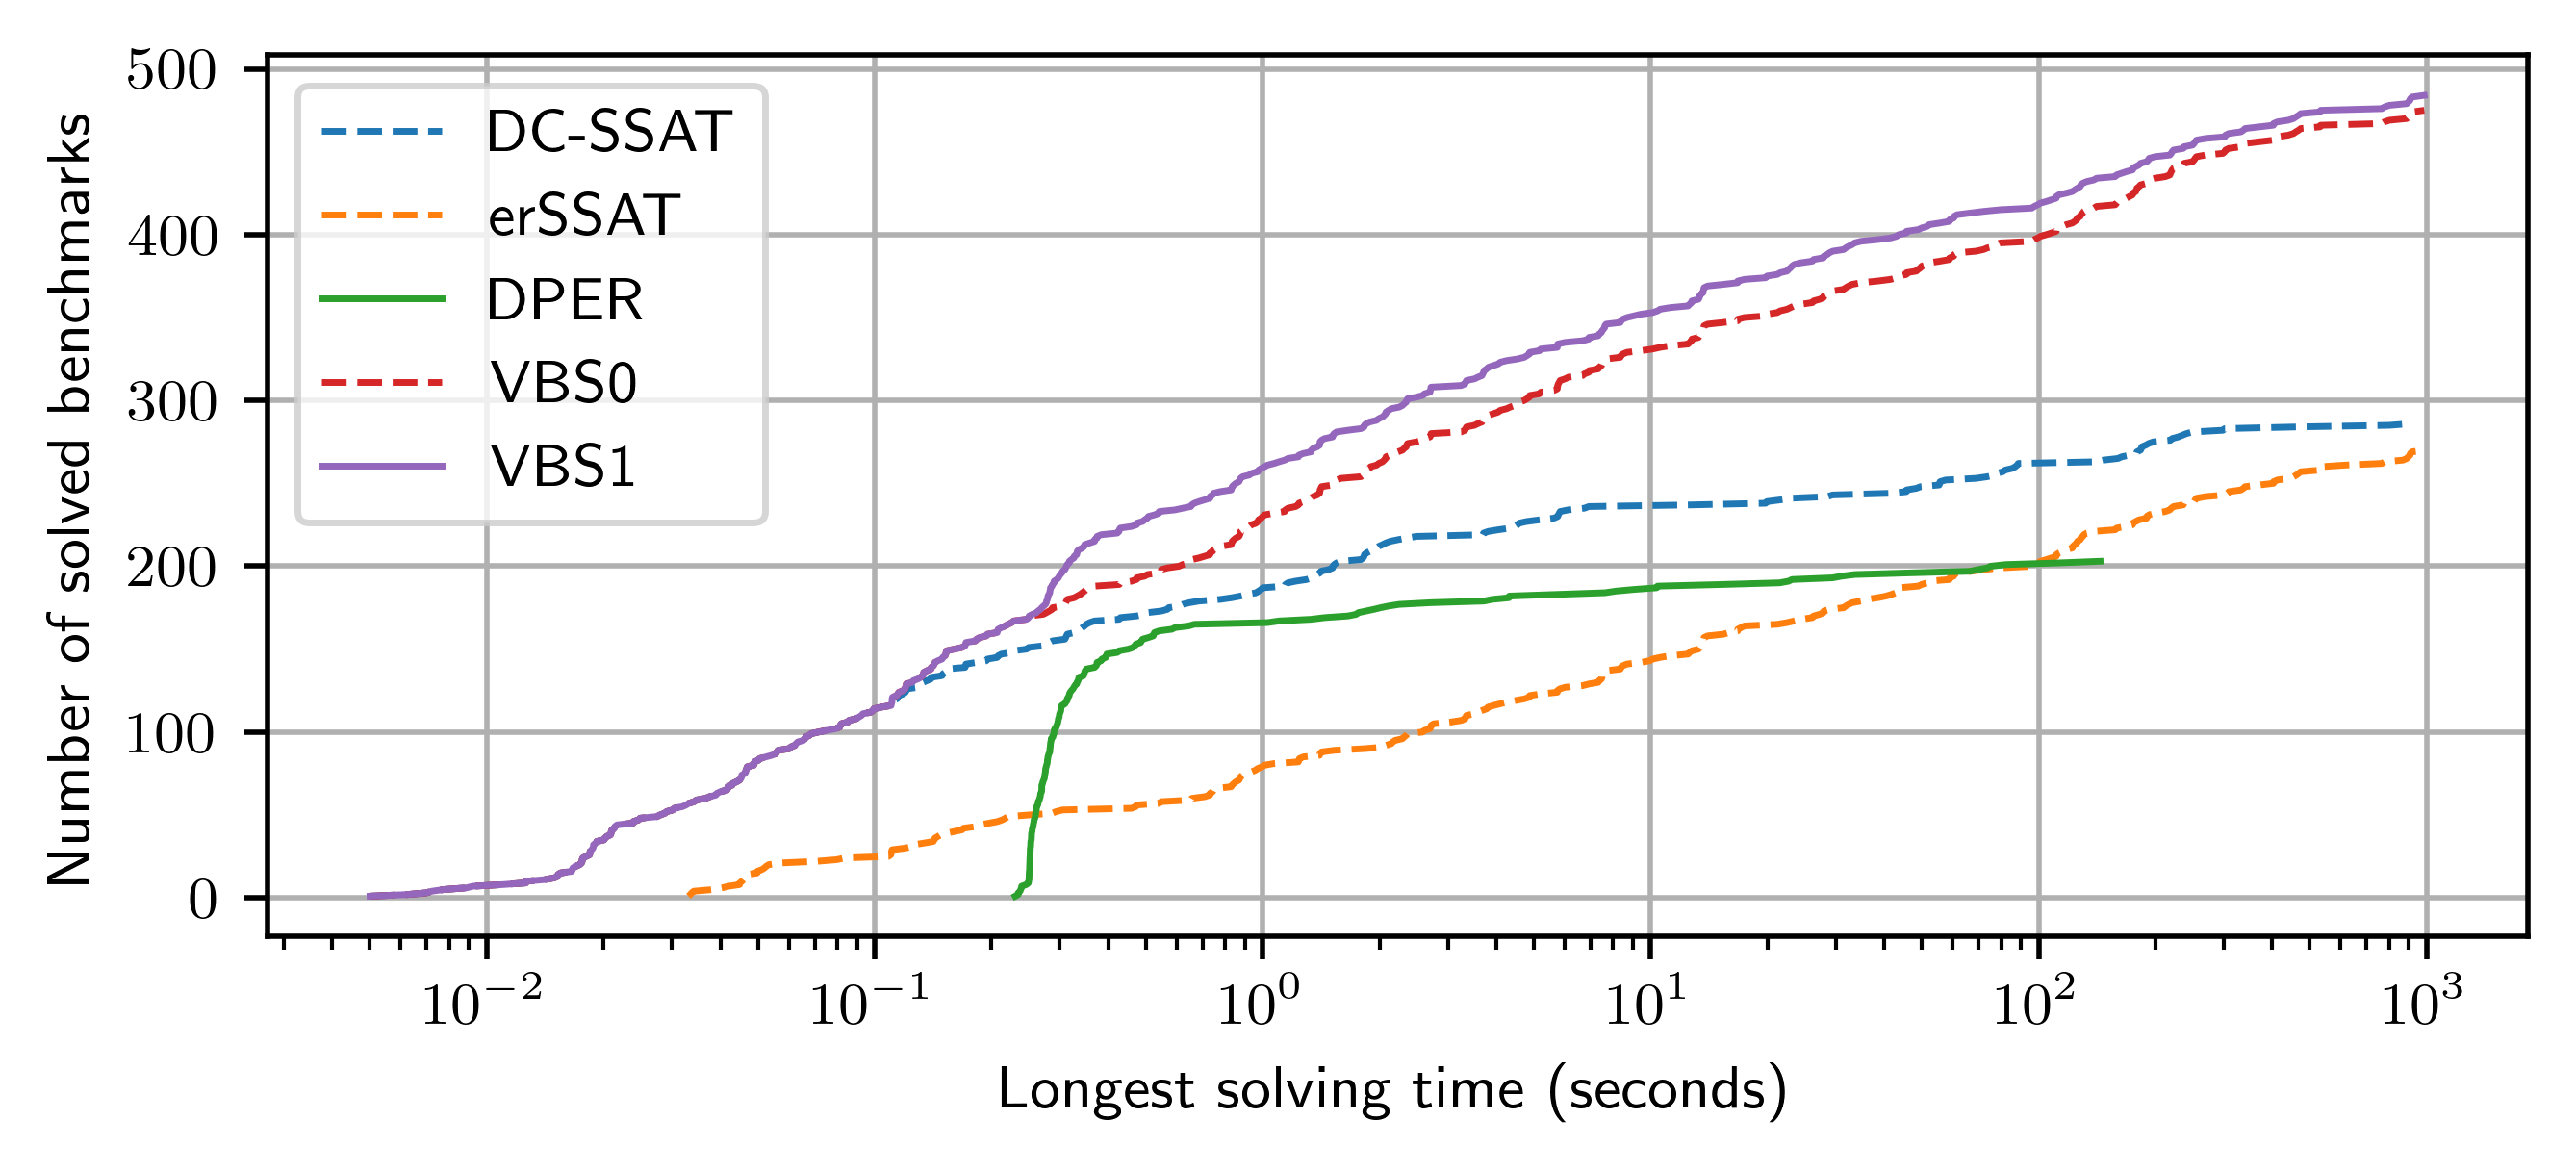

In [88]:
(fig, ax) = getFigAx(.4)

d = DIFF
m = HI_MEM
t = TIME

drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'DcH', d, m, t, 'DC-SSAT', '--')
drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'EGH', d, m, t, 'erSSAT', '--')
# drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'DpCHtd', d, m, t, 'DPMC CUDD htd', '-')
# drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'DpCHtd10s', d, m, t, 'DPMC CUDD htd-10s', '-')
drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'DpCF', d, m, t, 'DPER', '-')
# drawSolverCurve(ax, HI_WPMC_PERF_TABLE, 'DpCF5s', d, m, t, 'DPMC CUDD FlowCutter 5s', '-')


drawVbsCurve(ax, HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH'
], d, m, t, 'VBS0', '--')
drawVbsCurve(ax, HI_WPMC_PERF_TABLE, [
    'DcH',
    'EGH',
#     'DpCHtd',
#     'DpCHtd10s',
    'DpCF',
#     'DpCF5s'
], d, m, t, 'VBS1', '-')

# saveFig(fig, '~/code/dperpaper/figures/solvers.pgf')

In [89]:
def getTimesByWidthBySolver(
    table, suffixes, floatDiff, maxMem, maxTime
): # returns solver |-> (width |-> times)
    mapping = collections.defaultdict(dict)
    for (_, row) in table.iterrows():
        for suffix in suffixes:
            w = int(row['width1'])
            t = getQualifiedTime(row, suffix, floatDiff, maxMem, maxTime)
            if w in mapping[suffix]:
                mapping[suffix][w].append(t)
            else:
                mapping[suffix][w] = [t]
    return mapping

SUFFIXES = ['DcH', 'EGH', 'DpCHtd', 'DpCHtd10s', 'DpCF', 'DpCF5s']

# getTimesByWidthBySolver(WIDTH_TABLE, SUFFIXES, DIFF, maxMem=HI_MEM, maxTime=TIME)

In [90]:
def getTimesByWidthsBySolver(
    table, suffixes, floatDiff, maxMem, maxTime, widthCount
): # returns solver |-> (widths |-> times)
    mapping = collections.defaultdict(dict)
    for (solver, timesByWidth) in getTimesByWidthBySolver(
        table, suffixes, floatDiff, maxMem, maxTime
    ).items():
        timesByWidth = sorted(timesByWidth.items())
        for i in range(len(timesByWidth) - widthCount + 1):
            ws = ()
            ts = []
            for (width, times) in timesByWidth[i : i + widthCount]:
                ws += width,
                ts.extend(times)
            mapping[solver][ws] = ts
    return mapping

# getTimesByWidthsBySolver(WIDTH_TABLE, SUFFIXES, DIFF, maxMem=HI_MEM, maxTime=TIME, widthCount=2)

In [91]:
def getMeanPar2ScoreByWidthsBySolver(
    table, suffixes, floatDiff, maxMem, maxTime, widthCount
): # returns solver |-> (widths |-> score)
    mapping = collections.defaultdict(dict)
    timesByWidthsBySolver = getTimesByWidthsBySolver(
        table, suffixes, floatDiff, maxMem, maxTime, widthCount
    )
    for (suffix, timesByWidths) in timesByWidthsBySolver.items():
        for (widths, times) in timesByWidths.items():
            mapping[suffix][widths] = np.mean(getPar2Scores(times, maxTime))
    return mapping

# getMeanPar2ScoreByWidthsBySolver(WIDTH_TABLE, SUFFIXES, DIFF, HI_MEM, TIME, widthCount=2)

In [92]:
def getMeanPar2ScoreByMeanWidthBySolver(
    table, suffixes, floatDiff, maxMem, maxTime, widthCount
): # returns solver |-> (width |-> score)
    mapping = {}
    for (solver, scoreByWidths) in getMeanPar2ScoreByWidthsBySolver(
        table, suffixes, floatDiff, maxMem, maxTime, widthCount
    ).items():
        mapping[solver] = {np.mean(widths): score for (widths, score) in scoreByWidths.items()}
    return mapping

# getMeanPar2ScoreByMeanWidthBySolver(WIDTH_TABLE, SUFFIXES, DIFF, HI_MEM, TIME, widthCount=2)

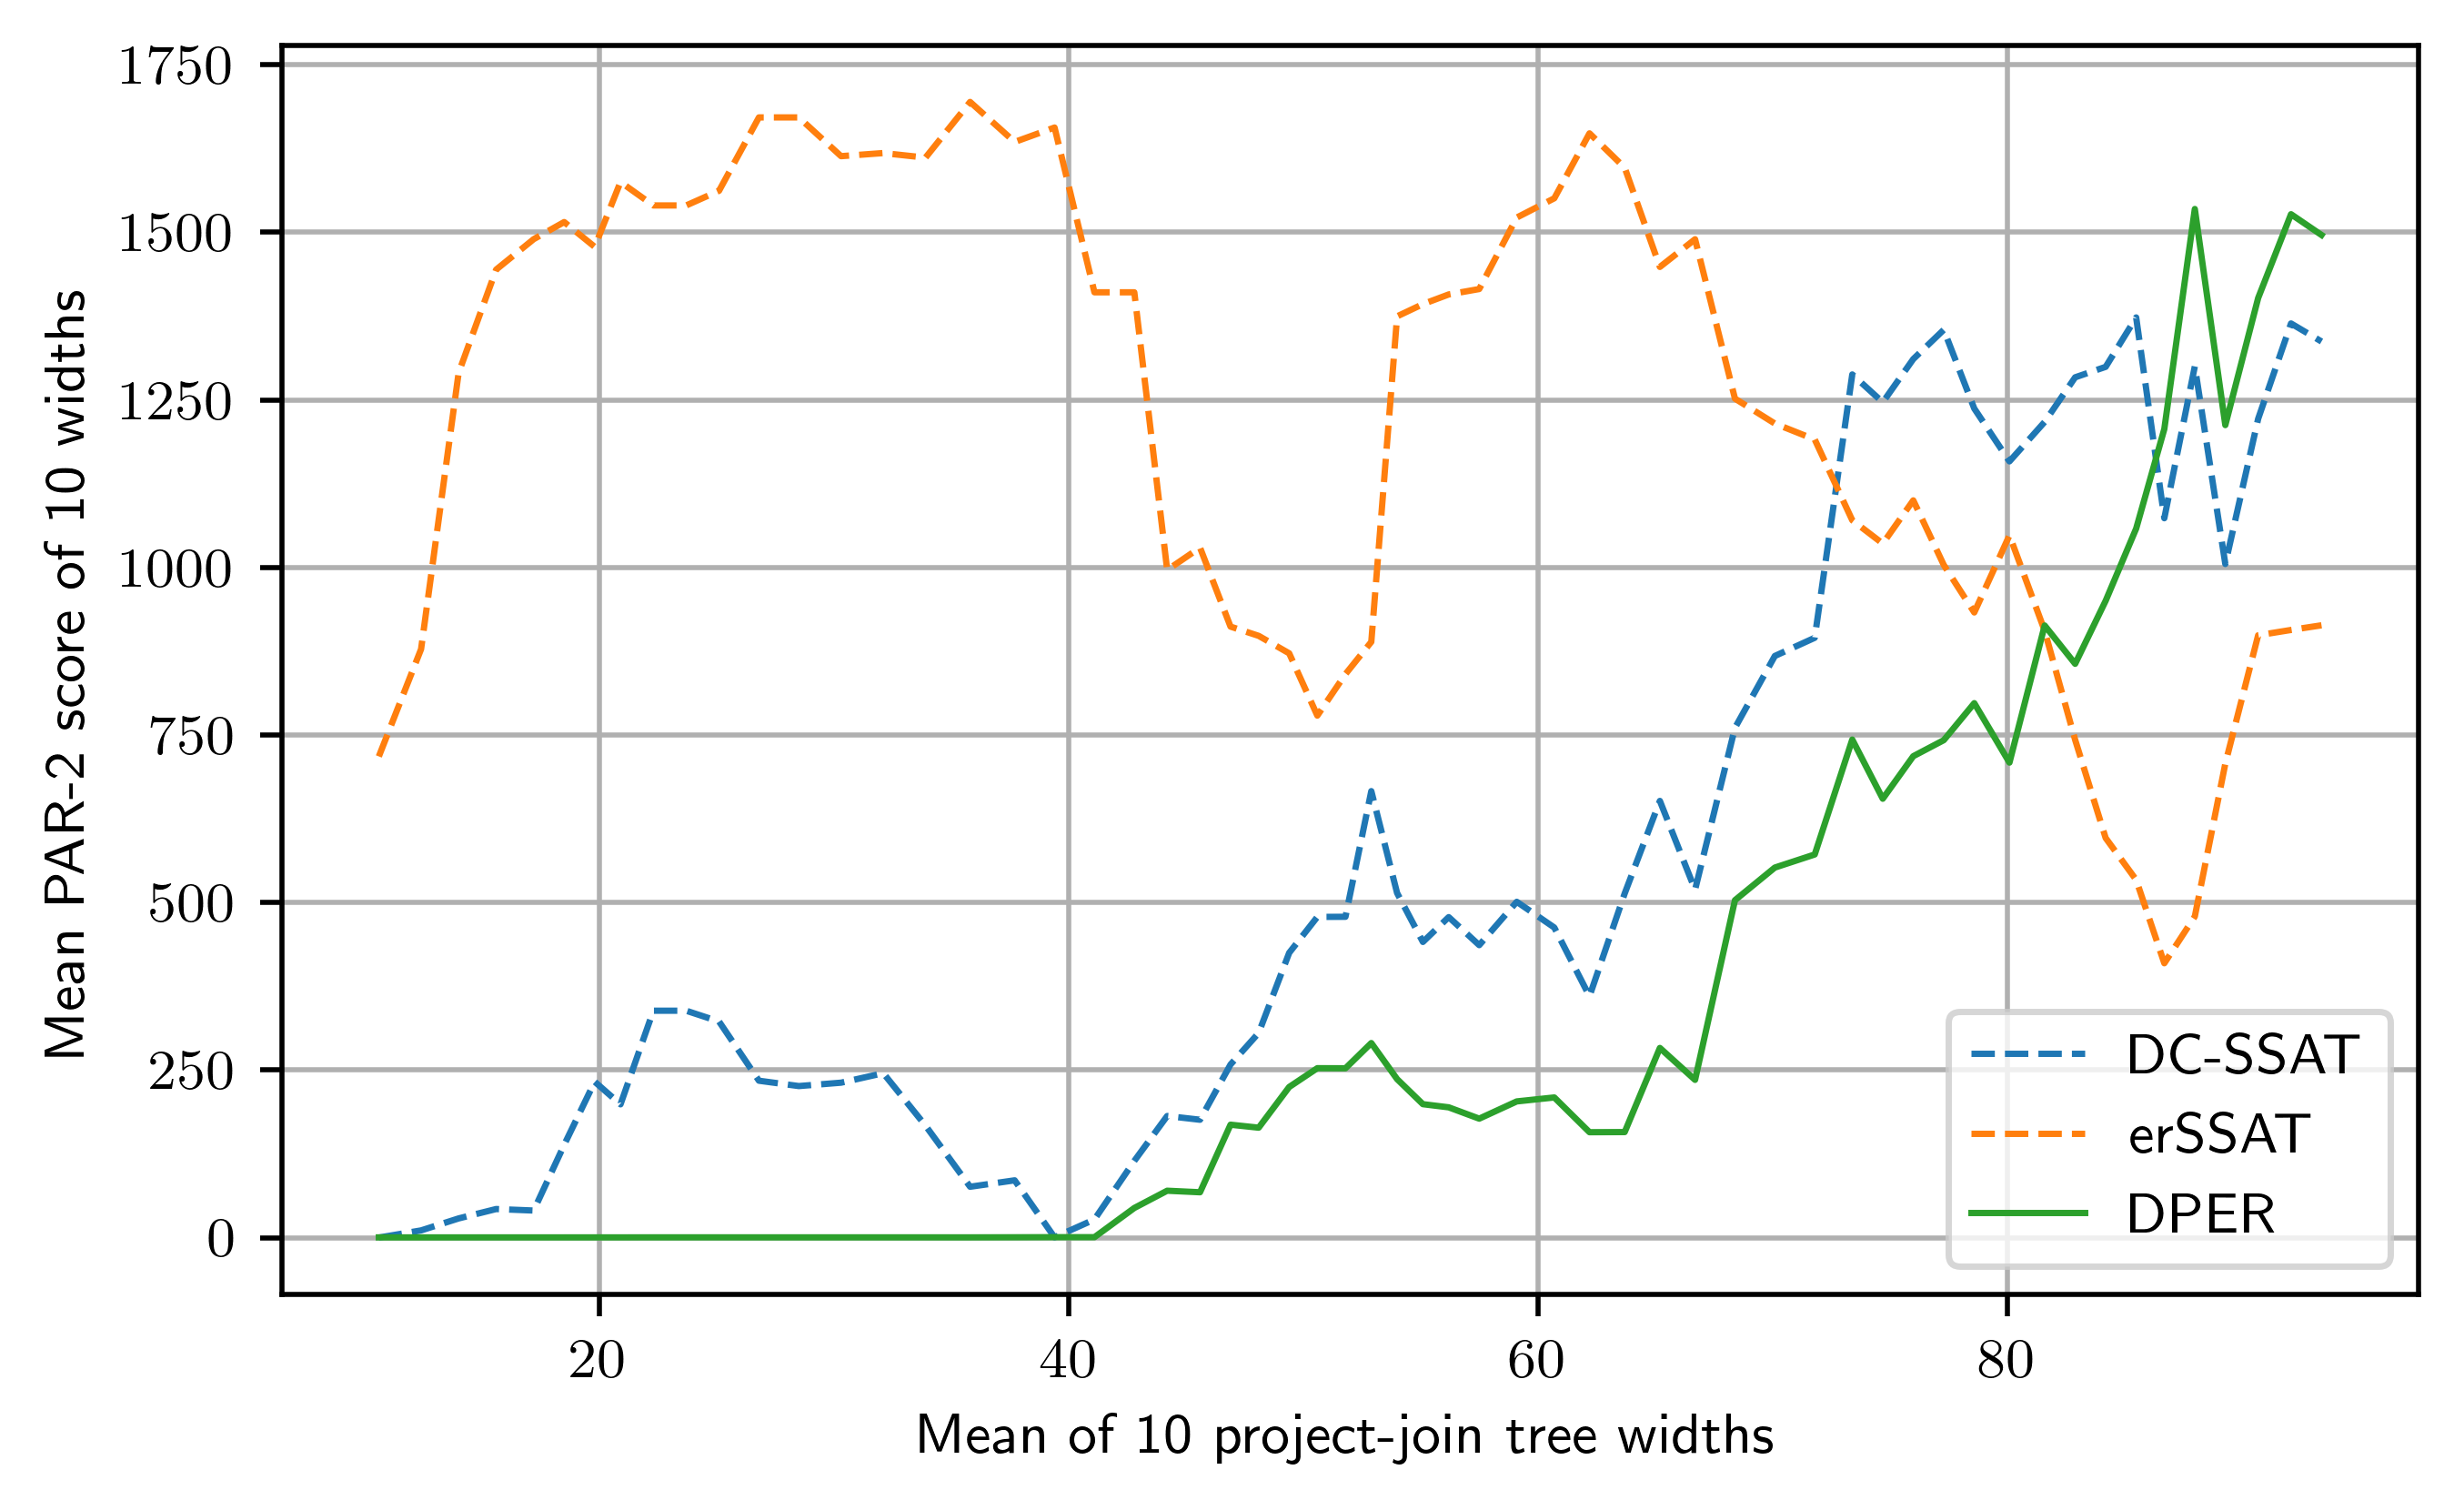

In [93]:
def drawWidthCurve(ax, table, suffixes, floatDiff, maxMem, maxTime, widthCount, suffix, label, style):
    m = getMeanPar2ScoreByMeanWidthBySolver(
        table, suffixes, floatDiff, maxMem, maxTime, widthCount
    )[suffix]
    ax.plot(m.keys(), m.values(), label=label, linestyle=style, linewidth=1)
    ax.legend()
    ax.set_xlabel(f'Mean of {widthCount} project-join tree widths')
    ax.set_ylabel(f'Mean PAR-2 score of {widthCount} widths')

(fig, ax) = getFigAx(.6)
d = DIFF
m = HI_MEM
t = TIME
w = 10

drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'DcH', 'DC-SSAT', '--')
drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'EGH', 'erSSAT', '--')
# drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'DpCHtd', 'DPMC CUDD htd', '-')
# drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'DpCHtd10s', 'DPMC CUDD htd 10s', '-')
drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'DpCF', 'DPER', '-')
# drawWidthCurve(ax, WIDTH_TABLE, SUFFIXES, d, m, t, w, 'DpCF5s', 'DPMC CUDD FlowCutter 5s', '-')

# saveFig(fig, '~/code/dperpaper/figures/widths.pgf')

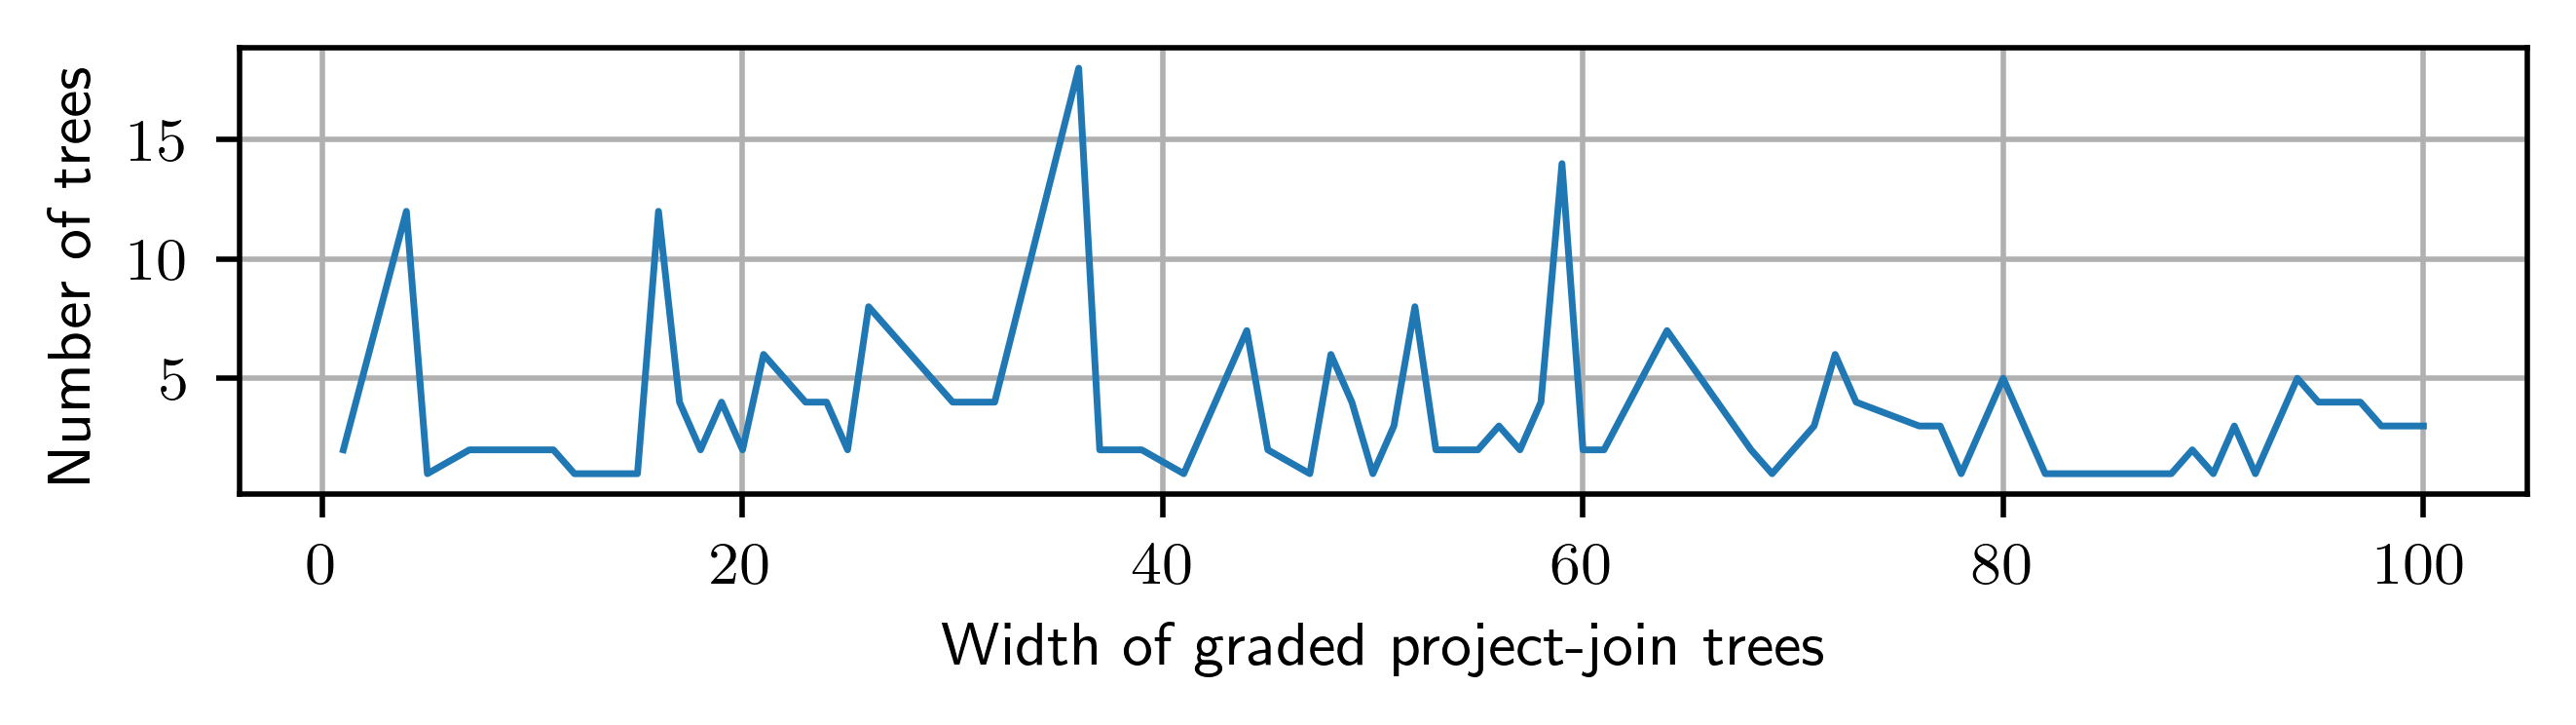

In [94]:
def drawWidths(ax):
    widths = collections.Counter()
    for (_, row) in WIDTH_TABLE.iterrows():
        widths[int(row['width1'])] += 1
    widths = sorted(widths.items())
    ax.plot(*zip(*widths), linewidth=1)
    ax.set_xlabel('Width of graded project-join trees')
    ax.set_ylabel('Number of trees')

(fig, ax) = getFigAx(.2)

drawWidths(ax)

#### Low mem

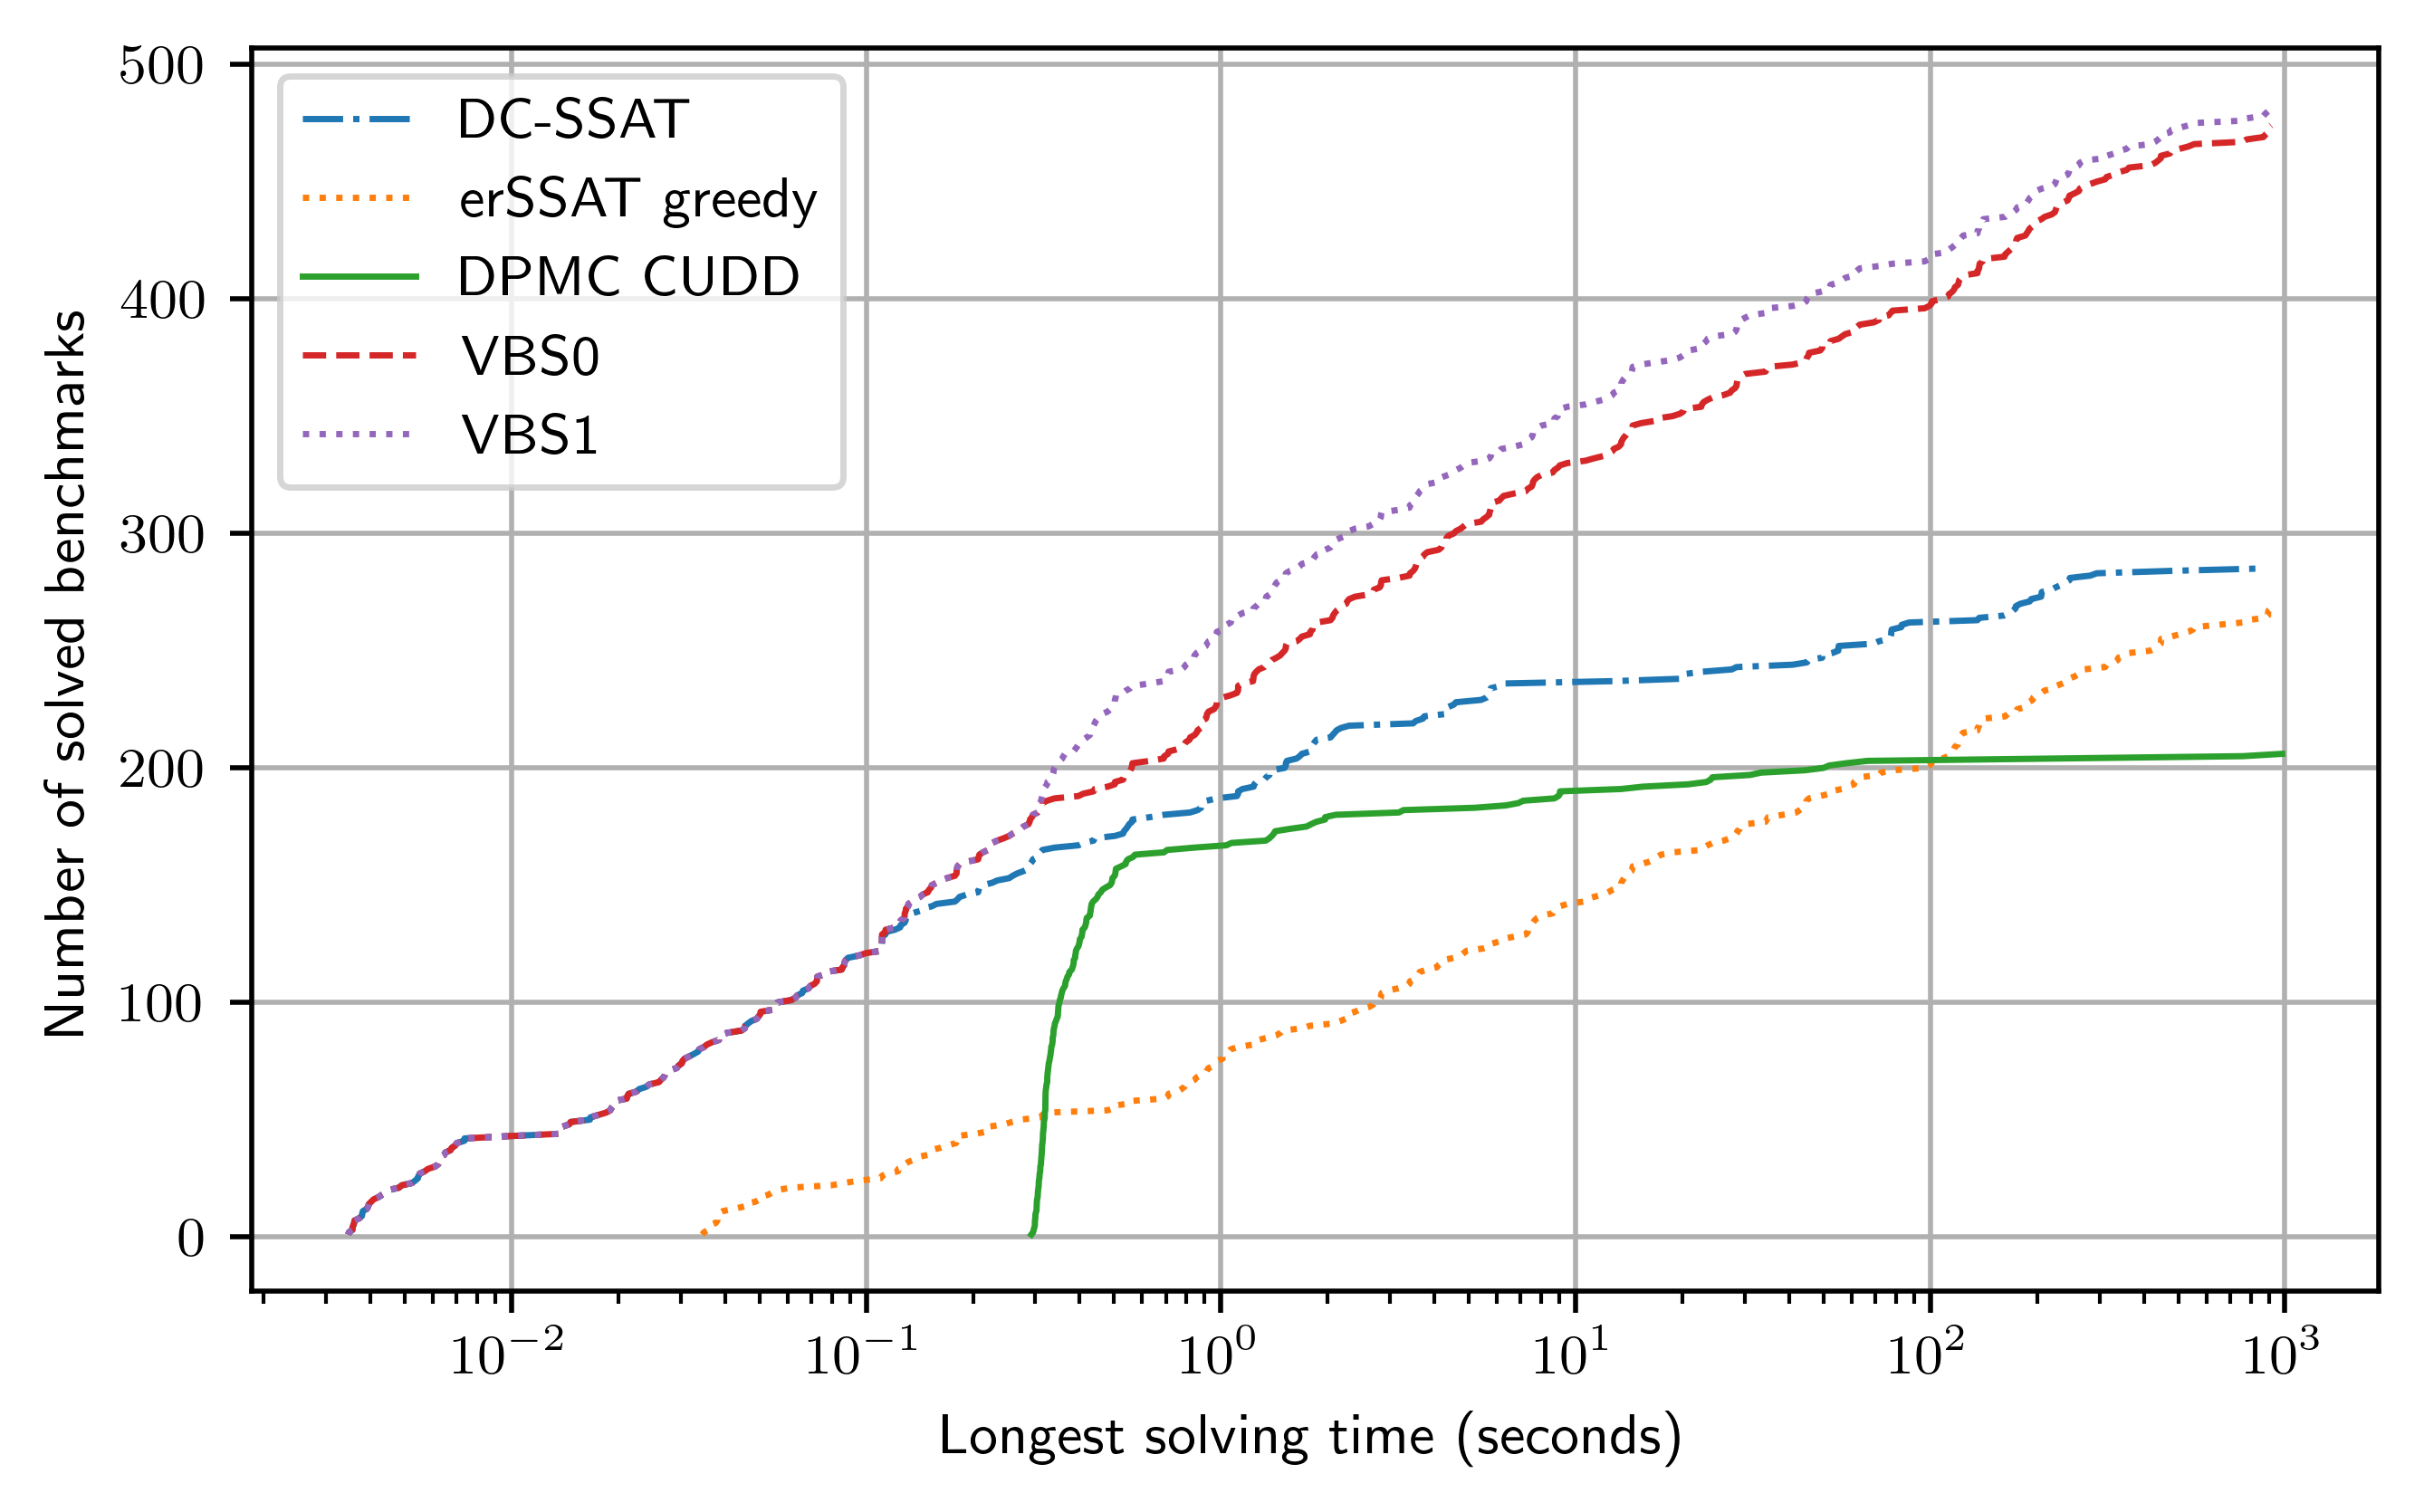

In [95]:
(fig, ax) = getFigAx(.6)

d = DIFF
m = LO_MEM
t = TIME

drawSolverCurve(ax, LO_WPMC_PERF_TABLE, 'Dc', d, m, t, 'DC-SSAT', '-.')
drawSolverCurve(ax, LO_WPMC_PERF_TABLE, 'EG', d, m, t, 'erSSAT greedy', ':')
# drawSolverCurve(ax, LO_WPMC_PERF_TABLE, 'EN', d, m, t, 'erSSAT non-greedy', ':')
drawSolverCurve(ax, LO_WPMC_PERF_TABLE, 'DpC', d, m, t, 'DPMC CUDD', '-')
# drawSolverCurve(ax, LO_WPMC_PERF_TABLE, 'DpS', d, m, t, 'DPMC Sylvan', '-')

drawVbsCurve(ax, LO_WPMC_PERF_TABLE, [
    'Dc',
    'EG'
], d, m, t, 'VBS0', '--')
drawVbsCurve(ax, LO_WPMC_PERF_TABLE, [
    'Dc',
    'EG',
    'DpC'
], d, m, t, 'VBS1', ':')

## Justicia benchmarks

### Tables

In [96]:
q = 'select base,sol,mem,time from data '

JUST_PERF_TABLE = JUST_DCSSAT_INST.getTable(q)
JUST_PERF_TABLE = JUST_PERF_TABLE.merge(JUST_ERSSAT_NOGREED_INST.getTable(q))
JUST_PERF_TABLE = JUST_PERF_TABLE.merge(JUST_DPMC_SYLVAN_INST.getTable(q))

JUST_PERF_TABLE

,base,solDc,memDc,timeDc,solEN,memEN,timeEN,solDpS,memDpS,timeDpS
0,adult_dt_sample_ER_2021_09_12_10_50_24_6549,0.208570,0.0,0.004204,0.208570,0.0,0.034602,0.208570,0.030000,0.297406
1,adult_dt_sample_ER_2021_09_12_10_50_24_68745,0.208570,0.0,0.004412,0.208570,0.0,0.053507,0.208570,0.036720,0.734964
2,adult_dt_sample_ER_2021_09_12_10_50_24_74501,0.954900,0.0,0.004496,0.954900,0.0,0.038232,0.954900,0.029456,0.423913
3,adult_dt_sample_ER_2021_09_12_10_50_24_79903,0.954900,0.0,0.004580,0.954900,0.0,0.041351,0.954900,0.048716,0.614471
4,adult_dt_sample_ER_2021_09_12_10_50_27_45689,0.955046,0.0,0.004822,0.955046,0.0,0.037593,0.955046,0.034732,0.292077
...,...,...,...,...,...,...,...,...,...,...
207,titanic_dt_sample_ER_2021_09_12_10_51_36_79563,0.815788,0.0,0.003265,0.815788,0.0,0.030699,0.815788,0.045412,0.228324
208,titanic_dt_sample_ER_2021_09_12_10_51_38_36194,1.000000,0.0,0.003131,1.000000,0.0,0.029877,1.000000,0.032144,0.230689
209,titanic_dt_sample_ER_2021_09_12_10_51_38_61132,1.000000,0.0,0.003730,1.000000,0.0,0.032378,1.000000,0.040008,0.224550
210,titanic_dt_sample_ER_2021_09_12_10_51_38_66847,1.000000,0.0,0.003514,1.000000,0.0,0.031108,1.000000,0.032672,0.232518


In [97]:
getUniqueCompletions(JUST_PERF_TABLE, [
    'Dc',
    'EN',
    'DpS'
], DIFF, LO_MEM, TIME)

Counter()

In [98]:
getFastestCompletions(JUST_PERF_TABLE, [
    'Dc',
    'EN',
    'DpS'
], DIFF, LO_MEM, TIME)

Counter({'Dc': 212})

### Figures

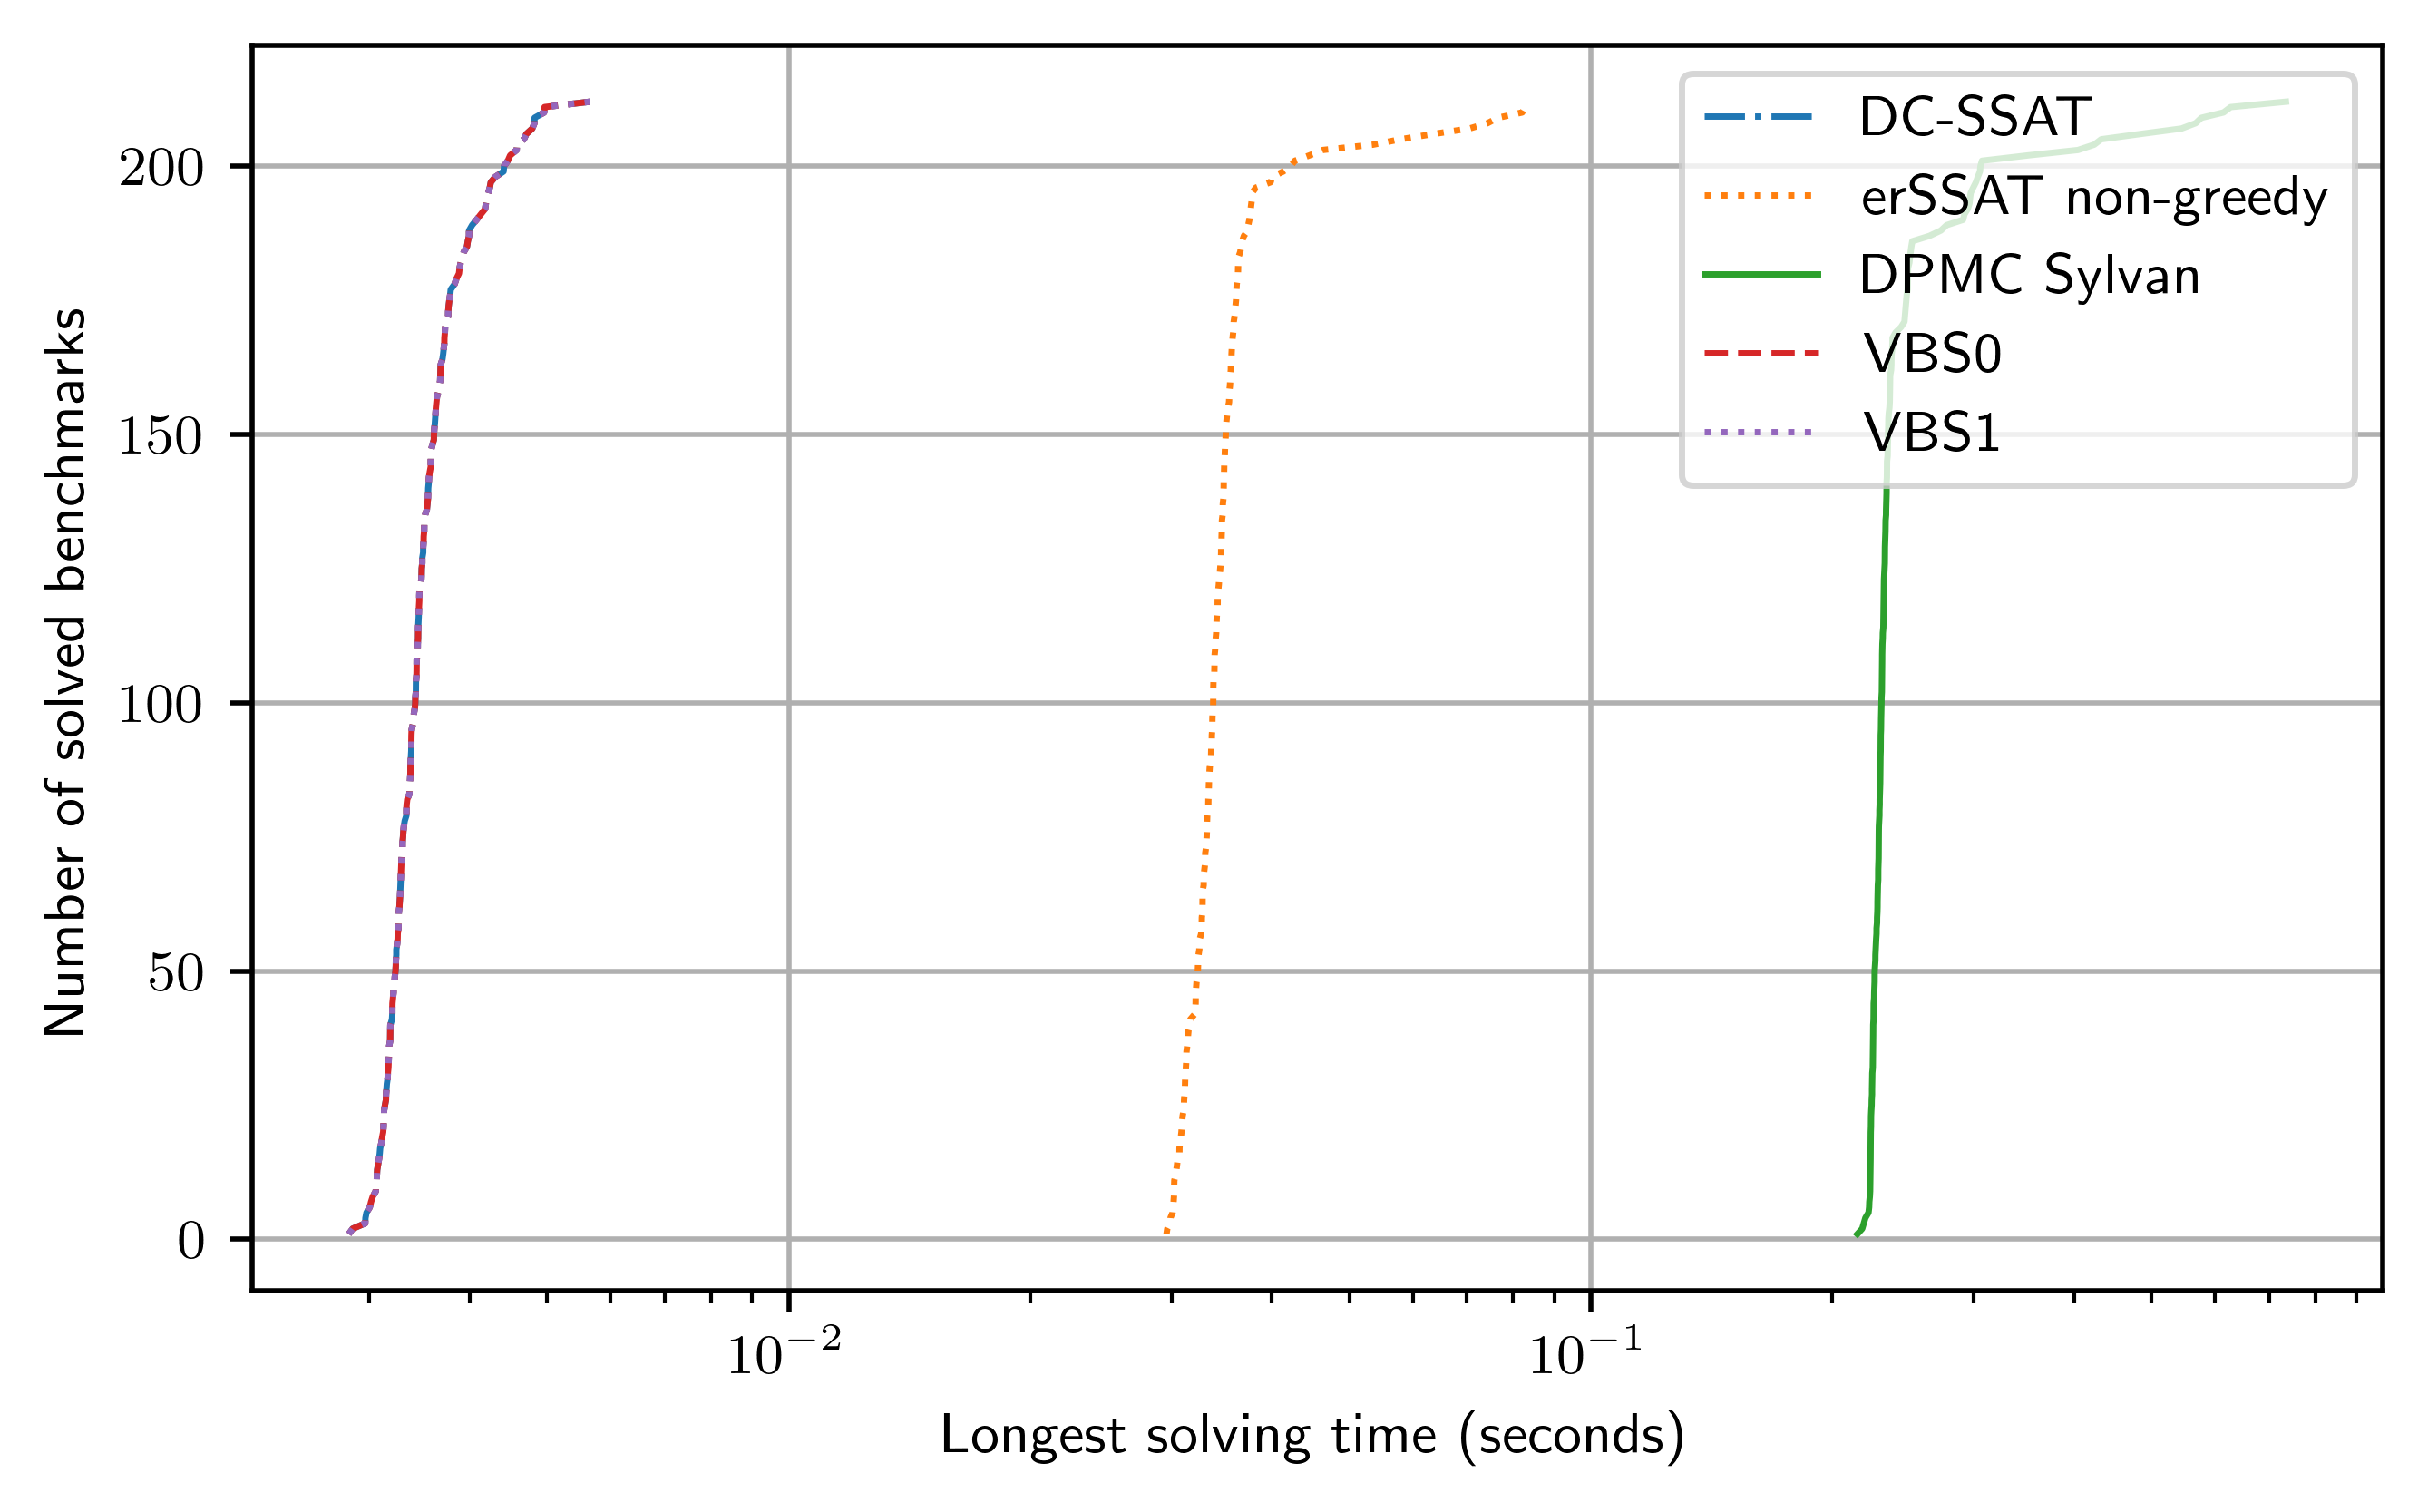

In [99]:
(fig, ax) = getFigAx(.6)

d = DIFF
m = LO_MEM
t = TIME

drawSolverCurve(ax, JUST_PERF_TABLE, 'Dc', d, m, t, 'DC-SSAT', '-.')

drawSolverCurve(ax, JUST_PERF_TABLE, 'EN', d, m, t, 'erSSAT non-greedy', ':')

drawSolverCurve(ax, JUST_PERF_TABLE, 'DpS', d, m, t, 'DPMC Sylvan', '-')

drawVbsCurve(ax, JUST_PERF_TABLE, 'Dc EN'.split(), d, m, t, 'VBS0', '--')
drawVbsCurve(ax, JUST_PERF_TABLE, 'Dc EN DpS'.split(), d, m, t, 'VBS1', ':')